In [1]:
!pip install InstructorEmbedding
!pip install sentence_transformers==2.2.2
!pip install datasets
!pip install transformers[torch]
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model

import re

# Loading the Processed Data

In [3]:
df_with_label = pd.read_csv('df_with_label.csv')
df_with_label.head()

,Unnamed: 0.1,Unnamed: 0,Prompt,Answer,Diet,Ingredients,NewIngre,NewPrompt
0,0,1631614,Ingredients: BREAD (UNBLEACHED ENRICHED WHEAT ...,Yes,do not want eggs,BREAD (UNBLEACHED ENRICHED WHEAT FLOUR [WHEAT ...,BREAD (UNBLEACHED ENRICHED WHEAT FLOUR [WHEAT ...,The dish contains: BREAD (UNBLEACHED ENRICHED ...
1,1,1364459,"Ingredients: KALE, CINDY'S TAHINI DRESSING HSH...",No,allergic to nuts,"KALE, CINDY'S TAHINI DRESSING HSH [FILTERED WA...","KALE, CINDY'S TAHINI DRESSING HSH [FILTERED WA...","The dish contains: KALE, CINDY'S TAHINI DRESSI..."
2,2,1329516,"Ingredients: CARBONATED WATER, HIGH FRUCTOSE C...",Yes,vegan,"CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CI...","CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CI...","The dish contains: CARBONATED WATER, HIGH FRUC..."
3,3,1141328,"Ingredients: WATER, ORGANIC MAPLE SYRUP, ORGAN...",Yes,vegan,"WATER, ORGANIC MAPLE SYRUP, ORGANIC LEMON JUIC...","WATER, ORGANIC MAPLE SYRUP, ORGANIC LEMON JUIC...","The dish contains: WATER, ORGANIC MAPLE SYRUP,..."
4,4,1254393,Ingredients: GRAPEFRUIT JUICE.. Category: Frui...,Yes,allergic to nuts,GRAPEFRUIT JUICE.. Category: Fruit & Vegetable...,GRAPEFRUIT JUICE.. Category: Fruit & Vegetable...,The dish contains: GRAPEFRUIT JUICE.. Category...


In [4]:
df_with_label.NewPrompt[0]

'The dish contains: BREAD (UNBLEACHED ENRICHED WHEAT FLOUR [WHEAT FLOUR, NIACIN, REDUCED IRON, THIAMIN MONONITRATE, RIBOFLAVIN, FOLIC ACID], WATER, SEA SALT, EXTRA VIRGIN OLIVE OIL, RYE FLOUR, WHOLE WHEAT FLOUR, YEAST, ASCORBIC ACID [DOUGH CONDITIONER]), BLACK FOREST HAM (CURED WITH WATER, SALT, SUGAR, DEXTROSE, SODIUM PHOSPHATE, HONEY, SODIUM ERYTHORBATE, SODIUM NITRITE, CARAMEL COLOR), TURKEY BREAST (TURKEY BREAST, TURKEY BROTH, SALT, SODIUM PHOSPHATES COATED WITH SALT, SPICE, PAPRIKA, PARSLEY, TURMERIC), SWISS CHEESE (PASTEURIZED MILK, CHEESE CULTURES, SALT, MICROBIAL ENZYMES), BACON (CURED WITH WATER, SALT, SUGAR, NATURAL SMOKE FLAVOR, SODIUM PHOSPHATE, SODIUM ERYTHORBATE, SODIUM NITRITE), LETTUCE. Category: Prepared Subs & Sandwiches I am do not want eggs, can I have this dish or not?'

In [5]:
df_with_label['label'] = [1 if x=='No' else 0 for x in df_with_label['Answer']]

### (skip this when run model) Build Training Set Part 1 - basic diet

In [ ]:
def generate_prompt(row):
    prompt = f"Ingredients: {row['ingredients']}. Category: {row['branded_food_category']}."
    #prompt += f" Gluten: {'Yes' if row['is_gluten'] else 'No'}, Meat: {'Yes' if row['contains_meat'] else 'No'}, Shellfish: {'Yes' if row['contains_shellfish'] else 'No'}, Nuts: {'Yes' if row['contains_nuts'] else 'No'}, Diary: {'Yes' if row['contains_diary'] else 'No'}, Soy: {'Yes' if row['contains_soy'] else 'No'}, Egg: {'Yes' if row['contains_egg'] else 'No'}, Animal Byproducts: {'Yes' if row['contains_animal_byproducts'] else 'No'}."
    #prompt += f" Vegan: {'Yes' if row['is_vegan'] else 'No'}, Vegetarian: {'Yes' if row['is_vegetarian'] else 'No'}, Pescatarian: {'Yes' if row['is_pescatarian'] else 'No'}."
    if row['not_a_significant_source_of'] == row['not_a_significant_source_of']:
      prompt += f"Not a significant source of: {row['not_a_significant_source_of']}."
    return prompt

# Apply the function to each row in the DataFrame
df['ingredient_prompt'] = df.apply(generate_prompt, axis=1)
df.head(2)

NameError: name 'df' is not defined

In [ ]:
# Define common dietary restrictions
dietary_restrictions = [
    ("vegetarian", "is_vegetarian", 1),
    ("vegan", "is_vegan", 1),
    ("pescatarian", "is_pescatarian", 1),
    ("cannot have meat", "contains_meat", 0),
    ("lactose intolerant", "contains_diary", 0),
    ("not feeling like soy", "contains_soy", 0),
    ("do not want eggs", "contains_egg", 0),
    ("no animal products", "contains_animal_byproducts", 0),
    ("allergic to nuts", "contains_nuts", 0),
    ("gluten free diet", "is_gluten", 0),
    ("allergic to shellfish", "contains_shellfish", 0)
]

# Initialize an empty list to hold the training data
training_data = []

# Iterate over each row in the dataset
for _, row in df.iterrows():
    ingredient_prompt = row['ingredient_prompt']
    for diet_label, column_name, bool_indicator in dietary_restrictions:
        # Construct the prompt
        prompt = f"{ingredient_prompt} I am {diet_label}, can I have this dish or not?"
        # Determine the answer based on the column value
        answer = "Yes" if row[column_name] == bool(bool_indicator) else "No"
        training_data.append([prompt, answer])

# Convert the training data into a DataFrame
processed_df = pd.DataFrame(training_data, columns=["Prompt", "Answer"])

# Optionally, you can save this DataFrame to a CSV file for later use
#training_df.to_csv('/path/to/save/training_data.csv', index=False)
processed_df.head(5)

In [ ]:
processed_df.shape

In [ ]:
processed_df[processed_df.Answer=="No"].head(5)

In [ ]:
small_set = processed_df.sample(n=1500, random_state=42)
small_set.shape

In [ ]:
# Define a function to extract diet from the description
def extract_diet(text):
    match = re.search(r"I am (.*?), can I have this dish or not\?", text)
    return match.group(1) if match else None

# Define a function to extract ingredients
def extract_ingredients(text):
    match = re.search(r"Ingredients: (.*?). I am", text)
    return match.group(1) if match else None

# Apply the functions to create new columns
df_with_label['Diet'] = df_with_label['Prompt'].apply(extract_diet)
df_with_label['Ingredients'] = df_with_label['Prompt'].apply(extract_ingredients)

# Show the new DataFrame
print(df_with_label.head())

#Other processing:
# 1. truncate ingredients to be <450 words
# 2. (optional)IR: add context for the diet selected.


### (skip this when run model) Building training set - part 2
Rare restrictions, data first obtained from GPT4.

In [ ]:
import random

# Simulating more rare dietary restrictions and preferences
rare_dietary_restr = [
    "Alpha-gal Syndrome", "Histamine Intolerance", "favism", "with Phenylketonuria", "sensitive to nickel",
    "not feeling like mushroom", "don't like spinach", "a buddhist", "a muslim", 'Hindu',
    "on keto", "on a paleo diet"
]

# Generate 500 samples with simulated answers for rare diets
random.seed(42)  # For reproducibility

rare_samples = []
for _ in range(500):
    # Randomly pick a dietary restriction
    diet = random.choice(rare_dietary_restr)
    # Randomly pick a row from the dataset
    row = df.sample(n=1).iloc[0]
    prompt = f"{row['ingredient_prompt']} I am {diet}, can I have this dish or not?"
    rare_samples.append([row.index, prompt])

# Convert to DataFrame for saving
rare_samples_df = pd.DataFrame(rare_samples, columns=["Index", "Prompt"])

# Save the DataFrame to a CSV file for manual review
csv_file_path = "rare_dietary_samples_2.csv"
rare_samples_df.to_csv(csv_file_path, index=False)

csv_file_path


'rare_dietary_samples_2.csv'

In [ ]:
# question and choice generation
dietary_restr = ["vegetarian", "on a diet", "vegan", "pescatarian", "lactose intolerant", #common diet
                "allergic to nuts", "gluten free diet", "on keto", "on a paleo diet",    #common diet and allergy
                "Alpha-gal Syndrome", "Histamine Intolerance", "favism", "with Phenylketonuria",  "sensitive to nickel", #rare diet/allergy
                "not feeling like mushroom", "don't like spinach",   #personal perference
                "a buddhist", "a muslim", 'Hindu', # religious perference
                ]
questions = []
for i in dietary_restr:
    ques = "I am " + i + ", can I have this dish or not?"
    questions.append(ques)


In [ ]:
#Prompt for chatGPT-4: For each of the question below, give me an answer of yes or no, without any other words.
#then append the ingredient prompt and the question.
#Lastly, we manually went through the answers to and correct the ones that GPT 4 got wrong.
#Final dataset are in answers_dietary_restrictions.csv

rare_df = pd.read_csv('answers_dietary_restrictions.csv')
# this set also contains chat GPT 4 answers
rare_df_for_modeling = rare_df[["Prompt", "Answer"]]

final_df = pd.concat([small_set, rare_df_for_modeling])

In [ ]:
final_df.head()

,Prompt,Answer
1631614,Ingredients: BREAD (UNBLEACHED ENRICHED WHEAT ...,Yes
1364459,"Ingredients: KALE, CINDY'S TAHINI DRESSING HSH...",No
1329516,"Ingredients: CARBONATED WATER, HIGH FRUCTOSE C...",Yes
1141328,"Ingredients: WATER, ORGANIC MAPLE SYRUP, ORGAN...",Yes
1254393,Ingredients: GRAPEFRUIT JUICE.. Category: Frui...,Yes


In [ ]:
nickel_df = final_df[final_df['Prompt'].str.contains('sensitive to nickel')]
hindu_df = final_df[final_df['Prompt'].str.contains('Hindu')]
paleo_df = final_df[final_df['Prompt'].str.contains("on a paleo diet")]

In [ ]:
nickel_df.to_csv('nickel_df')
hindu_df.to_csv('hindu_df')
paleo_df.to_csv('paleo_df')

In [ ]:
exclude_strings = ['sensitive to nickel', 'Hindu', 'on a paleo diet']
pattern = '|'.join(exclude_strings)
filtered_df = final_df[~final_df['Prompt'].str.contains(pattern, case=False, regex=True)]
filtered_df.shape

(1884, 2)

In [ ]:
filtered_df.to_csv('final_df.csv')

In [ ]:
def truncate_string(input_string, max_words=480):
    words = input_string.split()
    num_words = len(words)

    if num_words > max_words:
        words = words[:max_words]
        truncated_string = ' '.join(words)
        return truncated_string

    return input_string

df_with_label['NewIngre'] = df_with_label['Ingredients'].apply(truncate_string)

0    BREAD (UNBLEACHED ENRICHED WHEAT FLOUR [WHEAT ...
1    KALE, CINDY'S TAHINI DRESSING HSH [FILTERED WA...
2    CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CI...
3    WATER, ORGANIC MAPLE SYRUP, ORGANIC LEMON JUIC...
4    GRAPEFRUIT JUICE.. Category: Fruit & Vegetable...
Name: NewIngre, dtype: object

In [ ]:
def generate_prompt(row):
    prompt = f"The dish contains: {row['NewIngre']} I am {row['Diet']}, can I have this dish or not?"
    return prompt

df_with_label['NewPrompt'] = df_with_label.apply(generate_prompt, axis=1)

### Splitting the Data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
final_df = df_with_label.copy()
# Step 1: Split into train and temporary set (70-30)
train_df, temp_df = train_test_split(final_df, test_size=0.3, random_state=42)

# Step 2: Split temporary set into validation and test sets (50-50)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [8]:
train_df.shape
# should be 1400, 9

(1400, 9)

## (skip this when running) Hugging Face Multiple Choice Model - baseline test

In [ ]:
def predict_with_multiple_choice(prompt):
    # Tokenize the inputs for multiple choice
    #inputs = tokenizer([[prompt, 'Yes'], [prompt, 'No']], return_tensors="tf", padding=True)
    inputs = tokenizer([[prompt, 'Yes'], [prompt, 'No']], return_tensors="tf", padding=True)
    outputs = model({k: tf.expand_dims(v, 0) for k, v in inputs.items()})
    logits = outputs.logits
    predicted_class = int(tf.math.argmax(logits, axis=-1)[0])
    return predicted_class

In [ ]:
#example test
prompt = "France has a bread law, Le Décret Pain, with strict rules on what is allowed in a traditional baguette. Does the law apply to baguettes"
candidate1 = "Yes."
candidate2 = "No."

inputs = tokenizer([[prompt, candidate1], [prompt, candidate2]], return_tensors="tf", padding=True)
outputs = model({k: tf.expand_dims(v, 0) for k, v in inputs.items()})
int(tf.math.argmax(outputs.logits, axis=-1)[0])

0

In [ ]:
#predict_with_multiple_choice("A dish contains " + test_sample + "Does the dish contain red meat?")
predict_with_multiple_choice("I am allergic to shrimp, and there is shrimp in the dish. Can I eat shrimp?")

1

In [ ]:
predictions = []
for ques in train_df.NewPrompt:
  try:
    pred = predict_with_multiple_choice(ques)
    pred = "Yes" if pred == 0 else "No"
  except:
    print(ques)
    pred = 'Undetermined'
  predictions.append(pred)

predictions

Token indices sequence length is longer than the specified maximum sequence length for this model (1033 > 512). Running this sequence through the model will result in indexing errors


Ingredients: MACARONI AND CHEESE SAUCE: COOKED ENRICHED MACARONI (WATER, ENRICHED MACARONI [DURUM WHEAT SEMOLINA, NIACIN, FERROUS SULFATE {IRON}, THIAMINE MONONITRATE, RIBOFLAVIN, FOLIC ACID]), CHEDDAR CLUB CHEESE (PASTEURIZED CULTURED MILK, SALT, ENZYMES, ANNATTO COLORING), WHEY, MODIFIED CORN STARCH, WHEAT FLOUR, SOYBEAN OIL, WHEY PROTEIN CONCENTRATE, CHEDDAR CHEESE FLAVOR (WHEY, CHEESE [GRANULAR AND BLUE {PASTEURIZED MILK, CHEESE CULTURE, SALT, ENZYMES}], SUNFLOWER OIL, MALTODEXTRIN, SALT, SODIUM PHOSPHATE, CITRIC ACID, LACTIC ACID), BUTTER (CREAM, SALT), SALT, DISODIUM PHOSPHATE, MONO- AND DIGLYCERIDES, CITRIC ACID, CORN OIL, BETA CAROTENE (COLOR), TOCOPHEROLS. CHOCOLATE PUDDING: WATER, SUGAR, DAIRY PRODUCT SOLIDS (MODIFIED WHEY, REDUCED PROTEIN WHEY, WHEY SOLIDS), MODIFIED CORN STARCH, SWEET CREAM POWDER (SWEET CREAM, NONFAT MILK, SODIUM CASEINATE, TOCOPHEROL), COCOA POWDER, MALTODEXTRIN, ACETIC ACID ESTERS OF MONO- AND DIGLYCERIDES, SOY LECITHIN, SALT, SOYBEAN OIL, CELLULOSE GEL,

In [ ]:
train_df['baseline_prediction'] = predictions

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(train_df['Answer'], train_df['baseline_prediction'])
print(f"Accuracy Score: {accuracy}")

# Compute confusion matrix
labels = ['Yes', 'No', 'Undetermined']
cm = confusion_matrix(train_df['Answer'], train_df['baseline_prediction'], labels=labels)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#calculate accuracy score for each type of diet:
def calculate_accuracy(group):
    return accuracy_score(group['Answer'], group['baseline_prediction'])
accuracy_by_diet = train_df.groupby('Diet').apply(calculate_accuracy)
print(accuracy_by_diet)

## Preprocess and Tokenizing

Reference: https://towardsdatascience.com/multichoice-question-answering-in-huggingface-96f61eb88d18

In [9]:
from transformers import AutoTokenizer, TFAutoModelForMultipleChoice, pipeline

#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
#model = TFAutoModelForMultipleChoice.from_pretrained("bert-base-uncased")

In [10]:
import numpy as np
import pandas as pd
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    set_seed,
    DataCollatorWithPadding,
    DefaultDataCollator
)
from datasets import load_dataset, load_metric, Dataset
from dataclasses import dataclass, field
from typing import Optional, Union

In [11]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    token: str = field(
        default=None,
        metadata={
            "help": (
                "The token to use as HTTP bearer authorization for remote files. If not specified, will use the token "
                "generated when running `huggingface-cli login` (stored in `~/.huggingface`)."
            )
        },
    )
    use_auth_token: bool = field(
        default=None,
        metadata={
            "help": "The `use_auth_token` argument is deprecated and will be removed in v4.34. Please use `token` instead."
        },
    )
    trust_remote_code: bool = field(
        default=False,
        metadata={
            "help": (
                "Whether or not to allow for custom models defined on the Hub in their own modeling files. This option"
                "should only be set to `True` for repositories you trust and in which you have read the code, as it will "
                "execute code present on the Hub on your local machine."
            )
        },
    )

In [12]:
model_args = ModelArguments(model_name_or_path='bert-base-uncased', tokenizer_name='bert-base-uncased', cache_dir='./', use_fast_tokenizer=True)

In [13]:
@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    train_file: Optional[str] = field(default=None, metadata={"help": "The input training data file (a text file)."})

    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    max_seq_length: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "The maximum total input sequence length after tokenization. If passed, sequences longer "
                "than this will be truncated, sequences shorter will be padded."
            )
        },
    )
    pad_to_max_length: bool = field(
        default=False,
        metadata={
            "help": (
                "Whether to pad all samples to the maximum sentence length. "
                "If False, will pad the samples dynamically when batching to the maximum length in the batch. More "
                "efficient on GPU but very bad for TPU."
            )
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of training examples to this "
                "value if set."
            )
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
                "value if set."
            )
        },
    )


In [14]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
validation_dataset = Dataset.from_pandas(val_df)
data_args = DataTrainingArguments(train_file=train_dataset, validation_file=validation_dataset,
                      max_train_samples=len(train_dataset), max_eval_samples = len(validation_dataset))

In [15]:
model_name = model_args.model_name_or_path.split("/")[-1]

training_args = TrainingArguments(
    f"{model_name}-finetuned-demo",
    evaluation_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    do_train = True,
    do_eval = True,
    do_predict = True
)

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_args.tokenizer_name, use_fast=model_args.use_fast_tokenizer)

print(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


#### (skip during run) Test on tokenizer example

In [ ]:
val_df.shape

(300, 8)

In [ ]:
# repeat each question four times, add it to first_sentences list
examples = validation_dataset
first_sentences = []
for example in examples:
  for i in range(2):
    first_sentences.append(example['NewPrompt'])

# add choices to second_sentences list
second_sentences = []
for example in validation_dataset:
  for choice in ['Yes', 'No']:
    second_sentences.append(choice)

In [ ]:
print(len(first_sentences), len(second_sentences))
#sanity check, number needs to be 2 times the df size

600 600


In [ ]:
max_seq_length = tokenizer.model_max_length
tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True, max_length=max_seq_length)
dic = {'input_ids':[], 'token_type_ids':[], 'attention_mask':[]}

for k, v in tokenized_examples.items():
    for i in range(0, len(v), 2):
        dic[k].append(v[i:i+2])

#### Creating a Preprocess Function and Mapping it to the Dataset

In [17]:
max_seq_length = tokenizer.model_max_length

def preprocess_function(examples):
    first_sentences = []
    second_sentences = []
    choice_list = ["Yes", "No"]
    for q in examples["NewPrompt"]:
      for i in range(2):
        first_sentences.append(q)
      for choice in choice_list:
        second_sentences.append(choice)

    # Tokenize
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True, max_length=max_seq_length)

    # Un-flatten
    dic = {'input_ids':[], 'token_type_ids':[], 'attention_mask':[]}

    for k, v in tokenized_examples.items():
        for i in range(0, len(v), 2):
            dic[k].append(v[i:i+2])

    return dic


encoded_train = train_dataset.map(preprocess_function, batched=True, remove_columns=['Unnamed: 0.1', 'Unnamed: 0', 'Prompt', 'Answer', 'Diet', 'Ingredients',
       'NewIngre', 'NewPrompt'])
encoded_validation = validation_dataset.map(preprocess_function, batched=True, remove_columns=['Unnamed: 0.1', 'Unnamed: 0', 'Prompt', 'Answer', 'Diet', 'Ingredients',
       'NewIngre', 'NewPrompt'])
encoded_test = test_dataset.map(preprocess_function, batched=True, remove_columns=['Unnamed: 0.1',  'Prompt', 'Diet', 'Ingredients',
       'NewIngre', 'NewPrompt'])

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

In [18]:
for item in encoded_validation[0]['input_ids']:
  print(len(item))

45
45


In [19]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import tensorflow as tf


@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="tf",
        )

        batch = {k: tf.reshape(v, (batch_size, num_choices, -1)) for k, v in batch.items()}
        batch["labels"] = tf.convert_to_tensor(labels, dtype=tf.int64)
        return batch

# Training the Model

#### Running the Baseline

In [20]:
import evaluate
accuracy = evaluate.load("accuracy")

In [21]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
from transformers import create_optimizer, TFAutoModelForMultipleChoice


batch_size = 4
##larger than 8 batch size would crash colab GPU with an OOM error.
num_train_epochs = 2
total_train_steps = (len(train_dataset) // batch_size) * num_train_epochs
optimizer, schedule = create_optimizer(init_lr=5e-5, num_warmup_steps=1, num_train_steps=total_train_steps)

model = TFAutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
tf_train_set = model.prepare_tf_dataset(
    encoded_train,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    encoded_validation,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)



You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [24]:
model.compile(optimizer=optimizer)

In [25]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=2)

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
350/350 [==============================] - 222s 414ms/step - loss: 0.5620 - val_loss: 0.5170
Epoch 2/2
350/350 [==============================] - 126s 360ms/step - loss: 0.4828 - val_loss: 0.5138


In [26]:
tf_test_set = model.prepare_tf_dataset(
    encoded_test,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

train_predictions = model.predict(tf_train_set)
validation_predictions = model.predict(tf_validation_set)
test_predictions = model.predict(tf_test_set)

76/76 [==============================] - 9s 117ms/step


In [27]:
predicted_train = np.argmax(train_predictions.logits, axis=-1)
predicted_val = np.argmax(validation_predictions.logits, axis=-1)
predicted_test = np.argmax(test_predictions.logits, axis=-1)

In [28]:
train_accuracy = accuracy.compute(predictions=predicted_train, references=train_df['label'].tolist())['accuracy']
validation_accuracy = accuracy.compute(predictions=predicted_val, references=val_df['label'].tolist())['accuracy']
test_accuracy = accuracy.compute(predictions=predicted_test, references=test_df['label'].tolist())['accuracy']

print(f"Train accuracy: {train_accuracy}")
print(f"Validation accuracy: {validation_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 0.6921428571428572
Validation accuracy: 0.77
Test accuracy: 0.7342192691029901


**Testing for Error** \\
During a manual review of our dataset, we realized we incorrectly labeled one of the questions. Below we test to see if our model captured enough nuance to correctly select the right choice

In [32]:
test_string = "Ingredients: ORGANIC ALMOND MILK (WATER, ORGANIC ALMONDS), ORGANIC DATES, ORGANIC CACAO POWDER, PINK HIMALAYAN SALT. Category: Plant Based Milk. I am vegan, can I have this dish or not?"

test = train_df[train_df['Prompt'] == test_string]

testing_dataset = Dataset.from_pandas(test)
encoded_testing_one = testing_dataset.map(preprocess_function, batched=True, remove_columns=['Unnamed: 0.1', 'Unnamed: 0', 'Prompt', 'Answer', 'Diet', 'Ingredients',
       'NewIngre', 'NewPrompt'])

tf_testing_set = model.prepare_tf_dataset(
    encoded_testing_one,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

testing_predictions = model.predict(tf_testing_set)

predicted_testing = np.argmax(testing_predictions.logits, axis=-1)
print(predicted_testing)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1/1 [==============================] - 0s 80ms/step
[0]


#### Finetuning Using GridSearch
We now use Grid Search to do hyperparameter tuning

In [41]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameters and their possible values
param_grid = {
    'epoch': [2, 4, 6, 8],
    'batch_size': [2,4]
}

In [42]:
# Define a table to store the values
df_param = pd.DataFrame(columns = ["epoch", "batch_size", "train_accuracy", "validation_accuracy", "test_accuracy"])
df_param

,epoch,batch_size,train_accuracy,validation_accuracy,test_accuracy


In [47]:
grid = ParameterGrid(param_grid)

try:
  # Due to memory issues, we run the gridsearch within a try-except block

    for params in grid:
      print("Training with hyperparameters:", params)

      # Copied from the previous model

      batch_size = params['batch_size']
      num_train_epochs = params['epoch']
      total_train_steps = (len(train_dataset) // batch_size) * num_train_epochs
      optimizer, schedule = create_optimizer(init_lr=5e-5, num_warmup_steps=1, num_train_steps=total_train_steps)

      model = TFAutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")

      # Need to add the code to change the actual parameters

      # Compile the model
      model.compile(optimizer=optimizer)
      model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=num_train_epochs)

      # Predict
      train_predictions = model.predict(tf_train_set)
      validation_predictions = model.predict(tf_validation_set)
      test_predictions = model.predict(tf_test_set)

      predicted_train = np.argmax(train_predictions.logits, axis=-1)
      predicted_val = np.argmax(validation_predictions.logits, axis=-1)
      predicted_test = np.argmax(test_predictions.logits, axis=-1)

      train_accuracy = accuracy.compute(predictions=predicted_train, references=train_df['label'].tolist())['accuracy']
      validation_accuracy = accuracy.compute(predictions=predicted_val, references=val_df['label'].tolist())['accuracy']
      test_accuracy = accuracy.compute(predictions=predicted_test, references=test_df['label'].tolist())['accuracy']

      df_param.loc[len(df_param)] = [params['epoch'], params['batch_size'], train_accuracy, validation_accuracy, test_accuracy]

      print(f"Train accuracy: {train_accuracy}")
      print(f"Validation accuracy: {validation_accuracy}")
      print(f"Test accuracy: {test_accuracy}")
except:
    pass


Training with hyperparameters: {'batch_size': 2, 'epoch': 2}


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
350/350 [==============================] - 202s 413ms/step - loss: 0.5985 - val_loss: 0.5603
Epoch 2/2
76/76 [==============================] - 9s 116ms/step
Train accuracy: 0.5635714285714286
Validation accuracy: 0.6533333333333333
Test accuracy: 0.6345514950166113
Training with hyperparameters: {'batch_size': 2, 'epoch': 4}


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
350/350 [==============================] - 208s 415ms/step - loss: 0.5869 - val_loss: 0.6796
Epoch 2/4
350/350 [==============================] - 125s 357ms/step - loss: 0.5859 - val_loss: 0.5507
Epoch 3/4
350/350 [==============================] - 124s 354ms/step - loss: 0.5229 - val_loss: 0.5335
Epoch 4/4
76/76 [==============================] - 9s 117ms/step
Train accuracy: 0.7128571428571429
Validation accuracy: 0.73
Test accuracy: 0.7043189368770764
Training with hyperparameters: {'batch_size': 2, 'epoch': 6}


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
350/350 [==============================] - 208s 416ms/step - loss: 0.6622 - val_loss: 0.6915
Epoch 2/6
350/350 [==============================] - 126s 360ms/step - loss: 0.6399 - val_loss: 0.5923
Epoch 3/6
350/350 [==============================] - 126s 359ms/step - loss: 0.6557 - val_loss: 0.6932
Epoch 4/6
350/350 [==============================] - 124s 354ms/step - loss: 0.6716 - val_loss: 0.6907
Epoch 5/6
350/350 [==============================] - 126s 360ms/step - loss: 0.6720 - val_loss: 0.6931
Epoch 6/6
76/76 [==============================] - 9s 117ms/step
Train accuracy: 0.6471428571428571
Validation accuracy: 0.6233333333333333
Test accuracy: 0.5714285714285714
Training with hyperparameters: {'batch_size': 2, 'epoch': 8}


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
350/350 [==============================] - 204s 419ms/step - loss: 0.5976 - val_loss: 0.5570
Epoch 2/8
350/350 [==============================] - 128s 366ms/step - loss: 0.5429 - val_loss: 0.5305
Epoch 3/8
350/350 [==============================] - 124s 355ms/step - loss: 0.4990 - val_loss: 0.5115
Epoch 4/8
350/350 [==============================] - 124s 356ms/step - loss: 0.4328 - val_loss: 0.5458
Epoch 5/8
350/350 [==============================] - 123s 352ms/step - loss: 0.3769 - val_loss: 0.5806
Epoch 6/8
350/350 [==============================] - 125s 358ms/step - loss: 0.3354 - val_loss: 0.5167
Epoch 7/8
350/350 [==============================] - 124s 352ms/step - loss: 0.5873 - val_loss: 0.6933
Epoch 8/8
76/76 [==============================] - 9s 115ms/step
Train accuracy: 0.6907142857142857
Validation accuracy: 0.75
Test accuracy: 0.7275747508305648
Training with hyperparameters: {'batch_size': 4, 'epoch': 2}


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
350/350 [==============================] - 204s 416ms/step - loss: 0.6019 - val_loss: 0.5484
Epoch 2/2
76/76 [==============================] - 9s 117ms/step
Train accuracy: 0.6928571428571428
Validation accuracy: 0.76
Test accuracy: 0.7408637873754153
Training with hyperparameters: {'batch_size': 4, 'epoch': 4}


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
350/350 [==============================] - 205s 416ms/step - loss: 0.5645 - val_loss: 0.5069
Epoch 2/4
350/350 [==============================] - 126s 359ms/step - loss: 0.4664 - val_loss: 0.4526
Epoch 3/4
350/350 [==============================] - 127s 363ms/step - loss: 0.4431 - val_loss: 0.4378
Epoch 4/4
76/76 [==============================] - 9s 117ms/step
Train accuracy: 0.63
Validation accuracy: 0.84
Test accuracy: 0.8372093023255814
Training with hyperparameters: {'batch_size': 4, 'epoch': 6}


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
350/350 [==============================] - 206s 420ms/step - loss: 0.5898 - val_loss: 0.6931
Epoch 2/6
350/350 [==============================] - 127s 364ms/step - loss: 0.6960 - val_loss: 0.6931
Epoch 3/6
350/350 [==============================] - 126s 359ms/step - loss: 0.6945 - val_loss: 0.6931
Epoch 4/6
350/350 [==============================] - 126s 360ms/step - loss: 0.6936 - val_loss: 0.6931
Epoch 5/6
350/350 [==============================] - 124s 356ms/step - loss: 0.6924 - val_loss: 0.6931
Epoch 6/6
76/76 [==============================] - 9s 115ms/step
Train accuracy: 0.7078571428571429
Validation accuracy: 0.7266666666666667
Test accuracy: 0.6976744186046512
Training with hyperparameters: {'batch_size': 4, 'epoch': 8}


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8
350/350 [==============================] - 207s 420ms/step - loss: 0.6340 - val_loss: 0.6523
Epoch 2/8
350/350 [==============================] - 127s 363ms/step - loss: 0.5847 - val_loss: 0.6109
Epoch 3/8
350/350 [==============================] - 125s 357ms/step - loss: 0.6451 - val_loss: 0.6777
Epoch 4/8
350/350 [==============================] - 125s 358ms/step - loss: 0.6572 - val_loss: 0.6050
Epoch 5/8
350/350 [==============================] - 125s 357ms/step - loss: 0.6065 - val_loss: 0.5503
Epoch 6/8
350/350 [==============================] - 125s 357ms/step - loss: 0.5457 - val_loss: 0.5523
Epoch 7/8
350/350 [==============================] - 125s 357ms/step - loss: 0.5161 - val_loss: 0.5736
Epoch 8/8
76/76 [==============================] - 9s 115ms/step
Train accuracy: 0.695
Validation accuracy: 0.7366666666666667
Test accuracy: 0.717607973421927


In [48]:
print(df_param)

   epoch  batch_size  train_accuracy  validation_accuracy  test_accuracy
0    2.0         2.0        0.563571             0.653333       0.634551
1    4.0         2.0        0.712857             0.730000       0.704319
2    6.0         2.0        0.647143             0.623333       0.571429
3    8.0         2.0        0.690714             0.750000       0.727575
4    2.0         4.0        0.692857             0.760000       0.740864
5    4.0         4.0        0.630000             0.840000       0.837209
6    6.0         4.0        0.707857             0.726667       0.697674
7    8.0         4.0        0.695000             0.736667       0.717608


In [49]:
# Download the gridsearch

df_param.to_csv('param_grid.csv')

from google.colab import files
files.download("param_grid.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Training the Best Model

In [24]:
# Best Performed Model: {'batch_size': 4, 'epoch': 4}

batch_size = 4
##larger than 8 batch size would crash colab GPU with an OOM error.
num_train_epochs = 4
total_train_steps = (len(train_dataset) // batch_size) * num_train_epochs
optimizer, schedule = create_optimizer(init_lr=5e-5, num_warmup_steps=1, num_train_steps=total_train_steps)

model_fine_tuned = TFAutoModelForMultipleChoice.from_pretrained("google-bert/bert-base-uncased")


All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
model_fine_tuned.compile(optimizer=optimizer)

In [26]:
model_fine_tuned.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=4)

Epoch 1/4


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
350/350 [==============================] - 225s 414ms/step - loss: 0.5552 - val_loss: 0.5719
Epoch 2/4
350/350 [==============================] - 125s 357ms/step - loss: 0.5130 - val_loss: 0.4979
Epoch 3/4
350/350 [==============================] - 123s 353ms/step - loss: 0.4443 - val_loss: 0.4802
Epoch 4/4
350/350 [==============================] - 123s 352ms/step - loss: 0.3584 - val_loss: 0.4480


In [27]:
train_predictions = model_fine_tuned.predict(tf_train_set)
validation_predictions = model_fine_tuned.predict(tf_validation_set)
test_predictions = model_fine_tuned.predict(tf_test_set)

76/76 [==============================] - 9s 116ms/step


In [28]:
predicted_train = np.argmax(train_predictions.logits, axis=-1)
predicted_val = np.argmax(validation_predictions.logits, axis=-1)
predicted_test = np.argmax(test_predictions.logits, axis=-1)

# Analysis of Model Performance

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

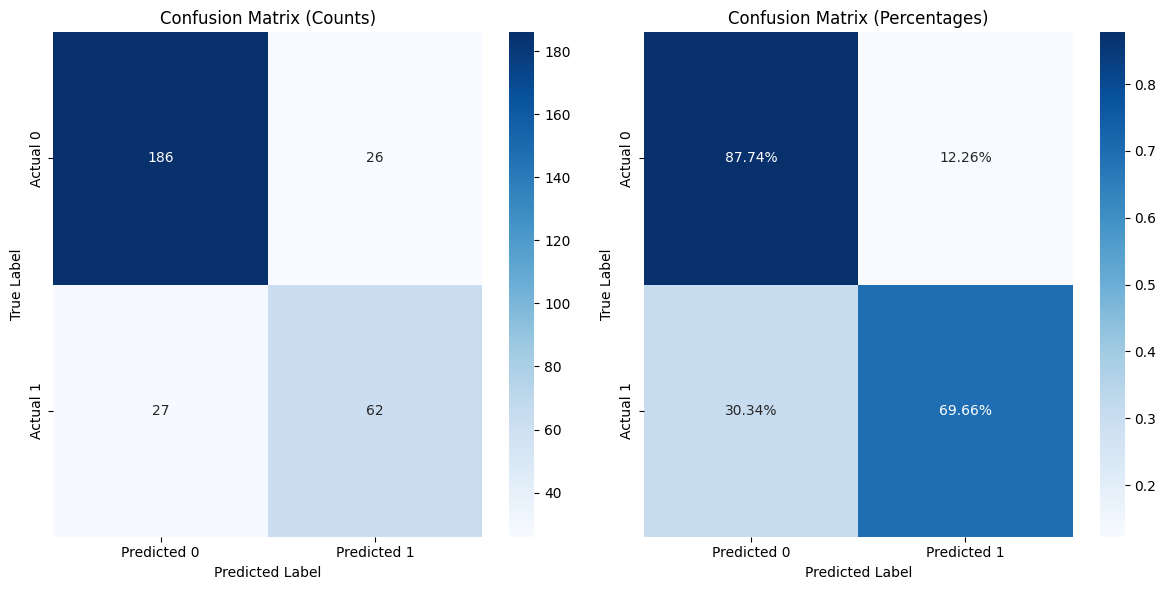

In [33]:
# Compute confusion matrices
cm_counts = confusion_matrix(test_df['label'].tolist(), predicted_test)
cm_percentages = cm_counts / np.sum(cm_counts, axis=1, keepdims=True)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix with counts
sns.heatmap(cm_counts, annot=True, cmap='Blues', fmt='g', ax=axes[0], xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Confusion matrix with percentages
sns.heatmap(cm_percentages, annot=True, cmap='Blues', fmt='.2%', ax=axes[1], xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1].set_title('Confusion Matrix (Percentages)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

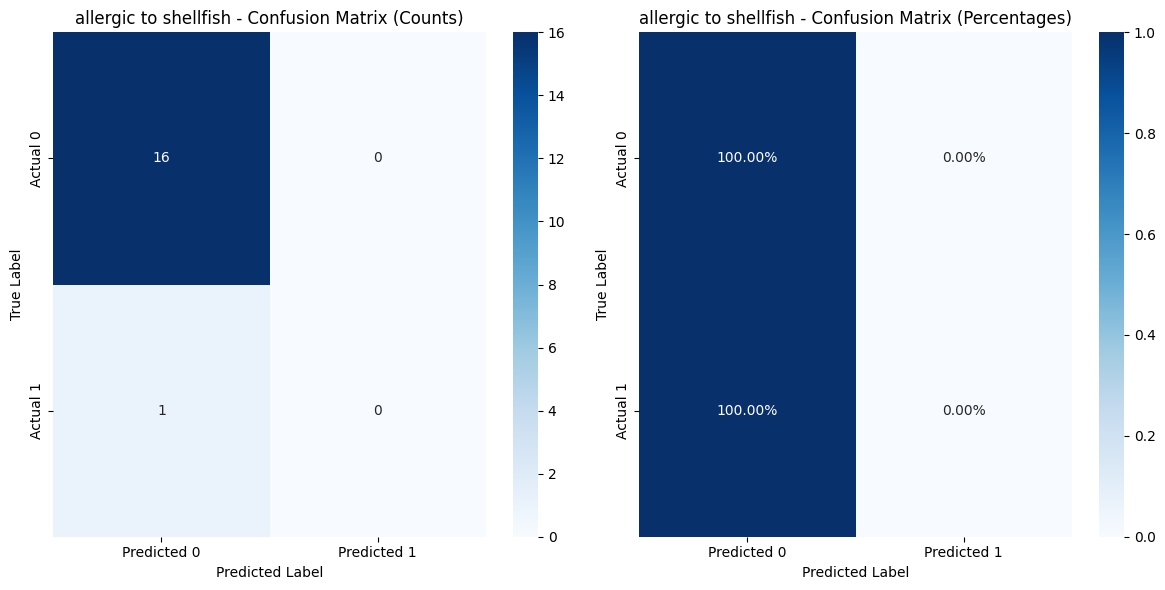

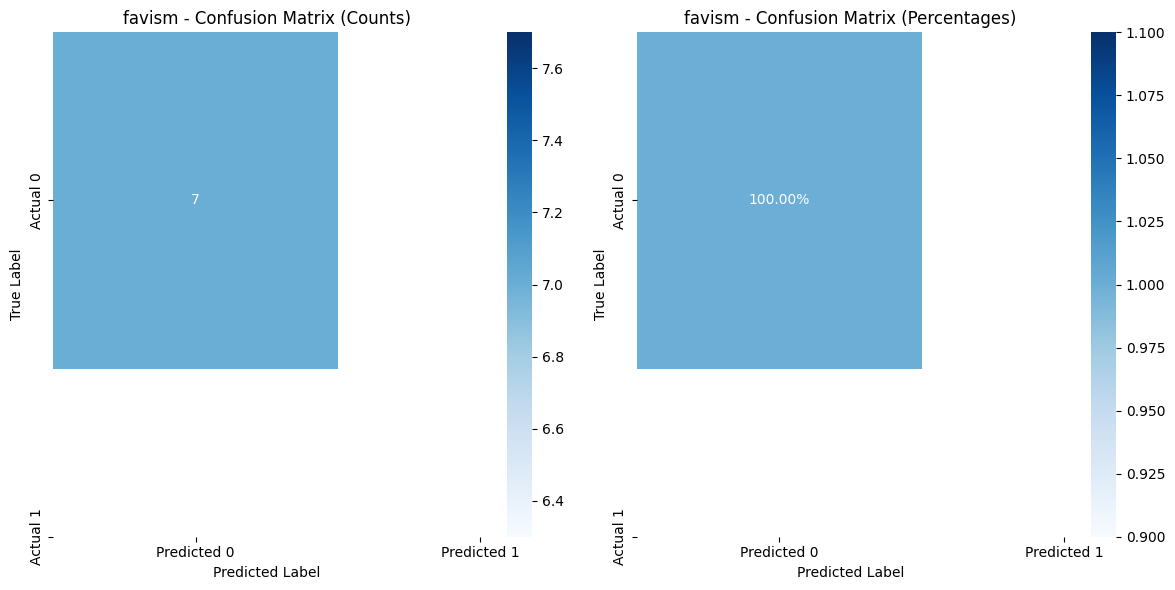

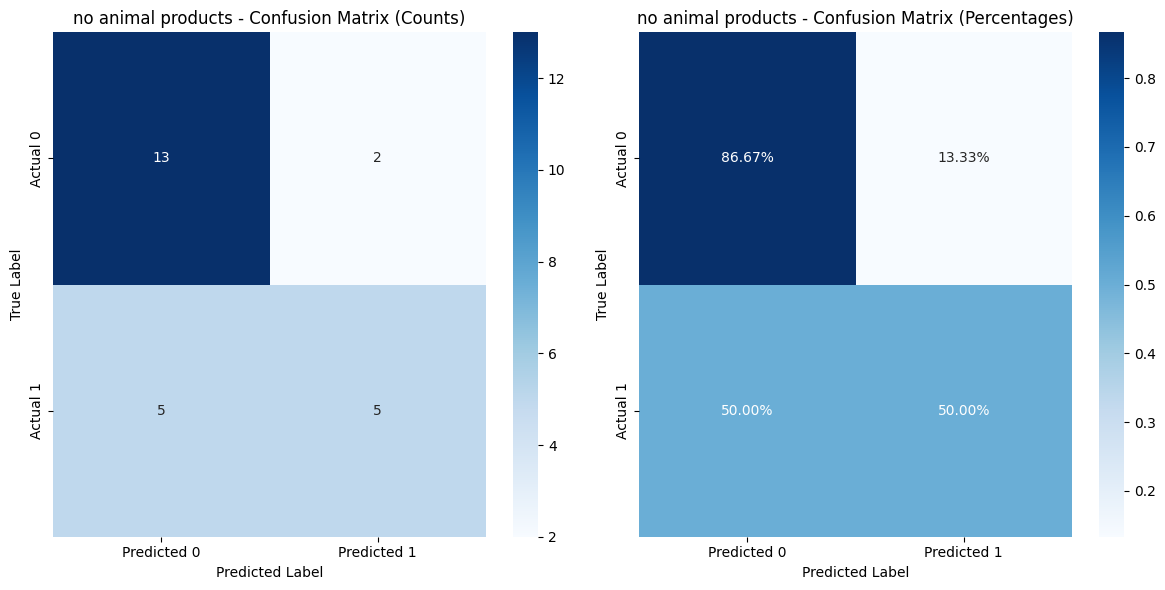

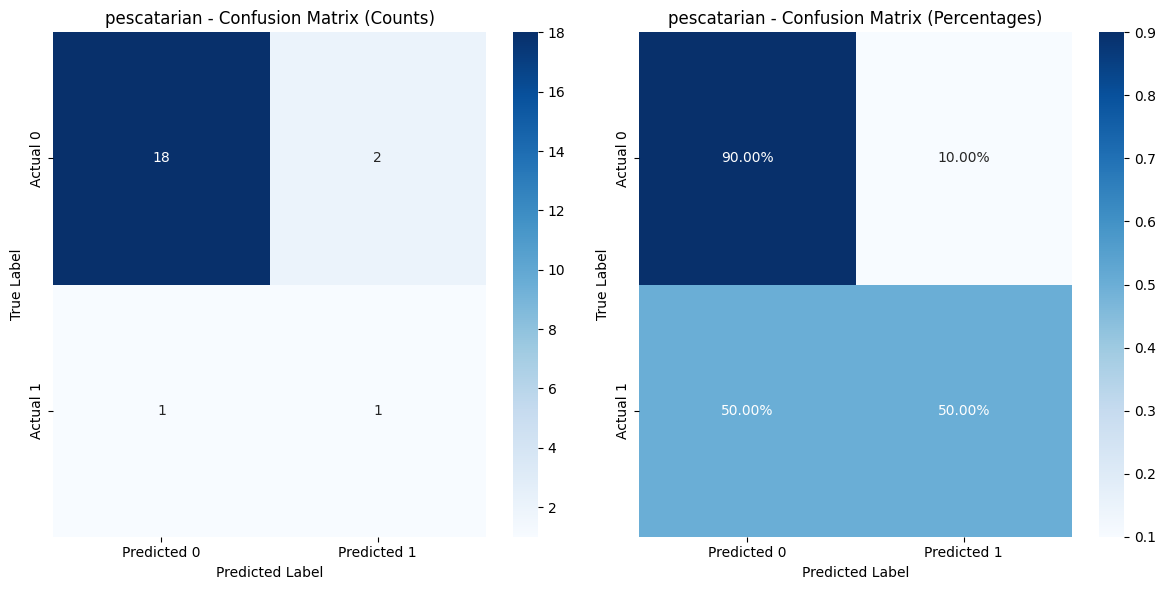

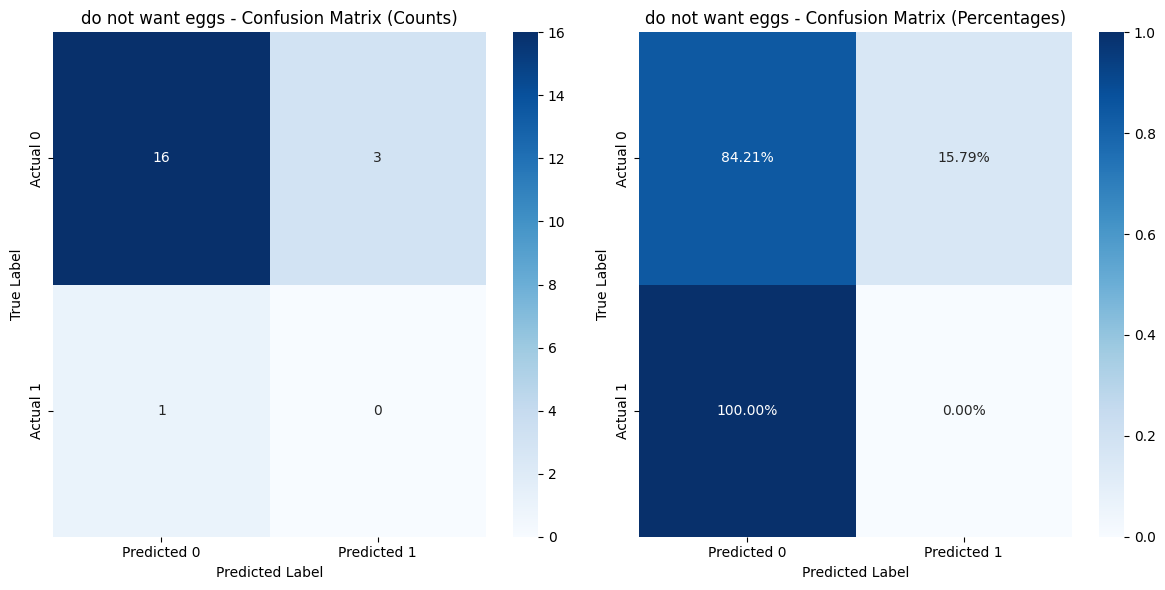

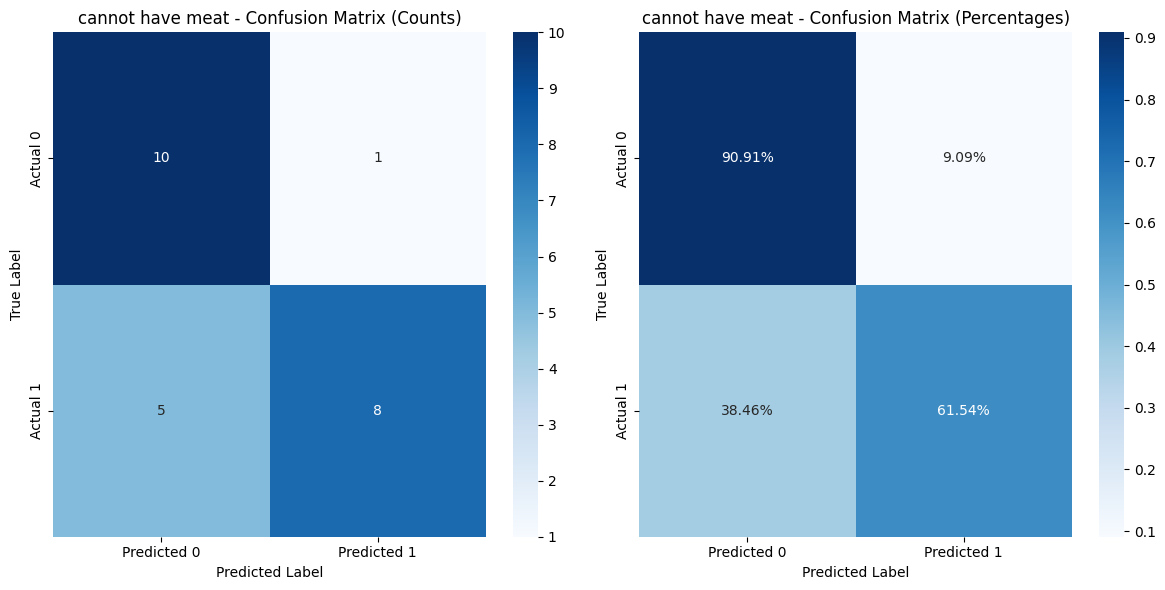

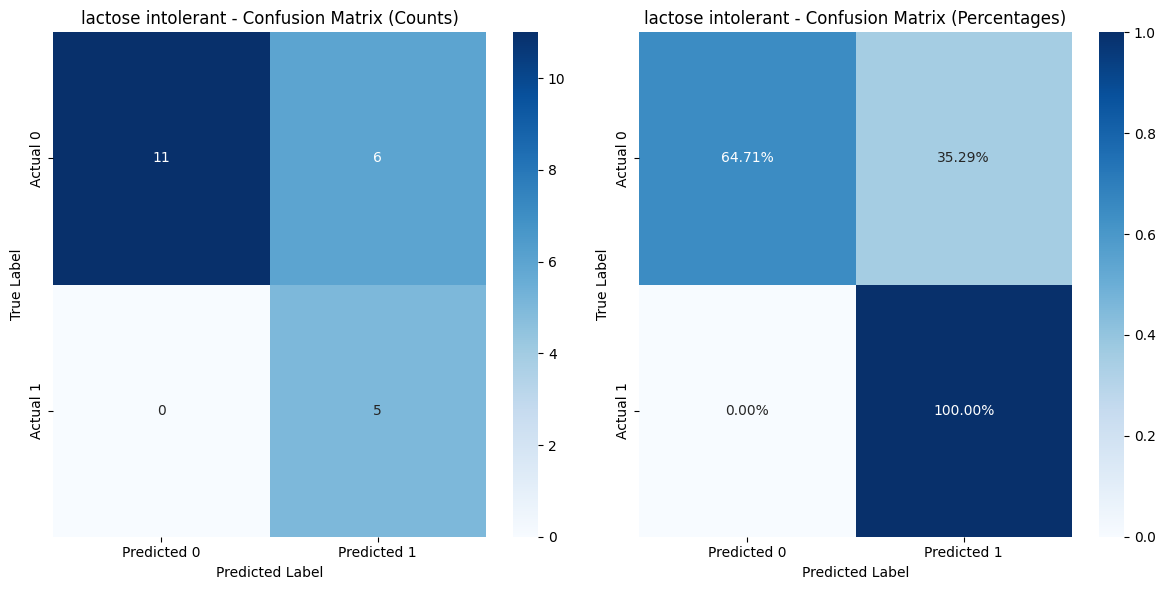

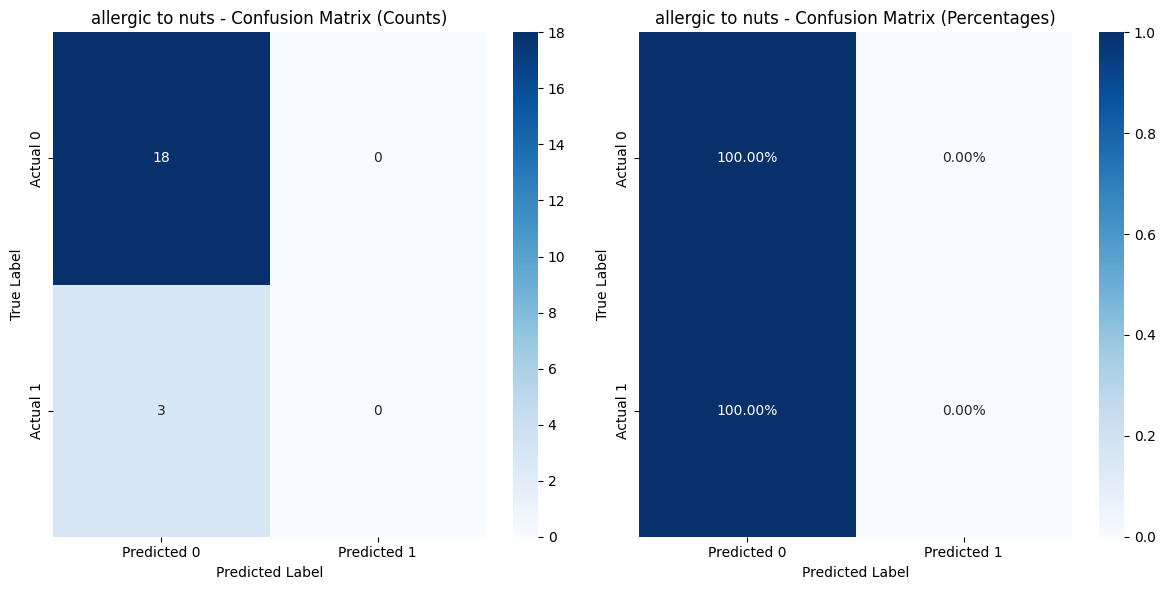

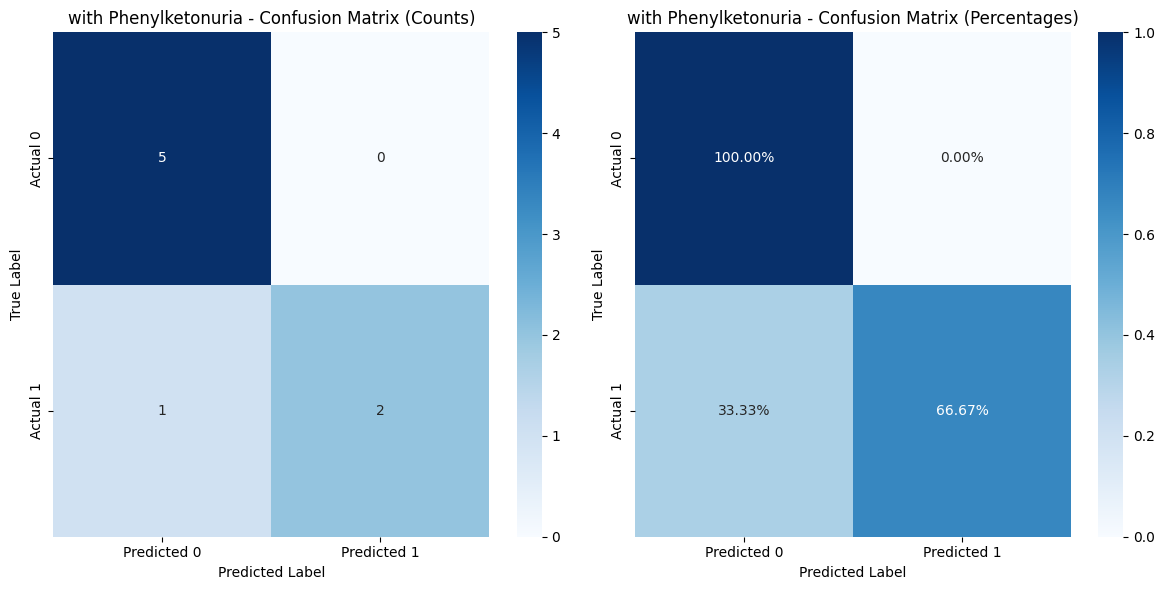

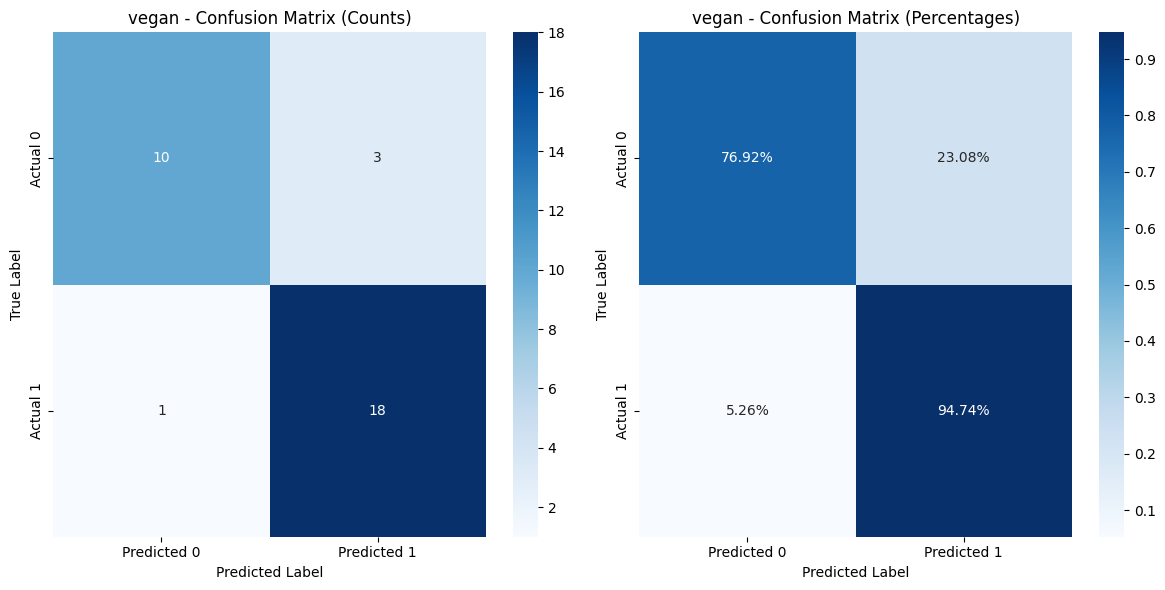

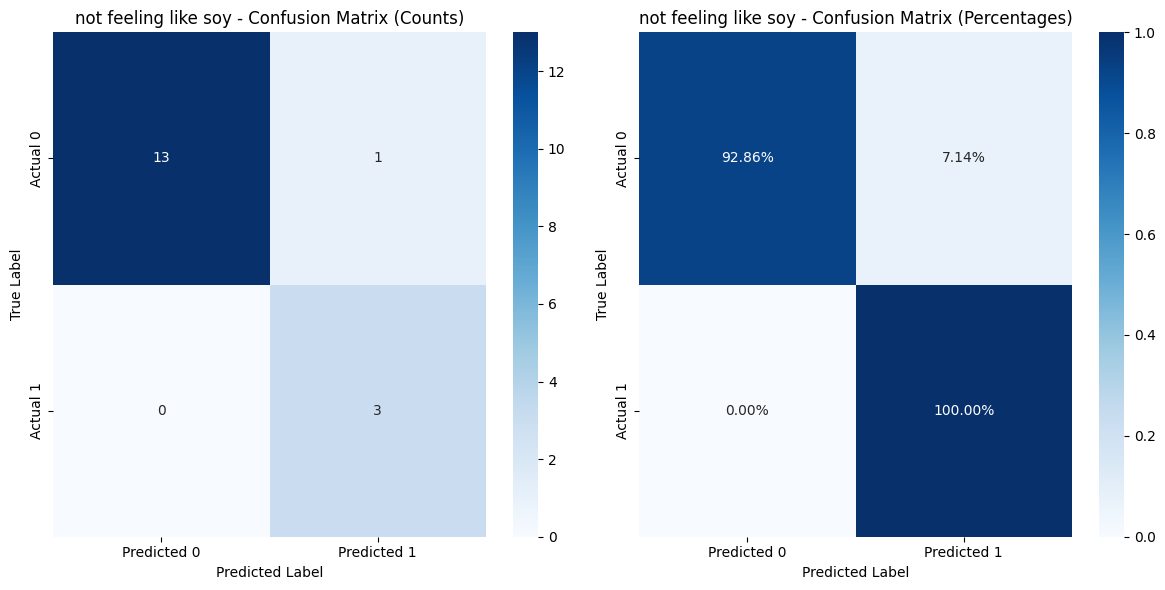

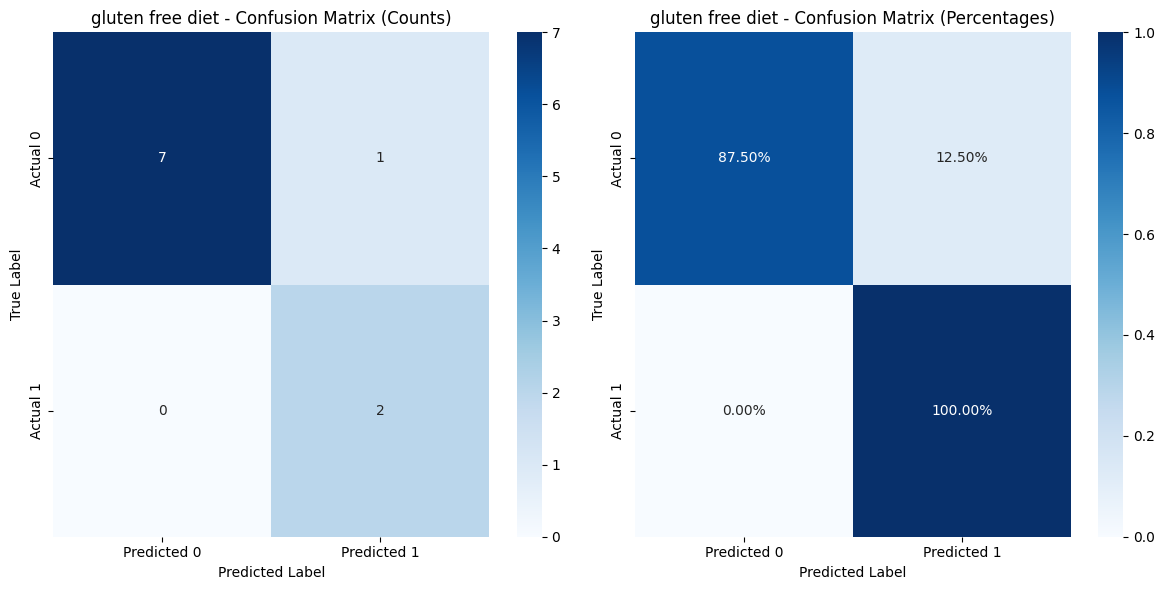

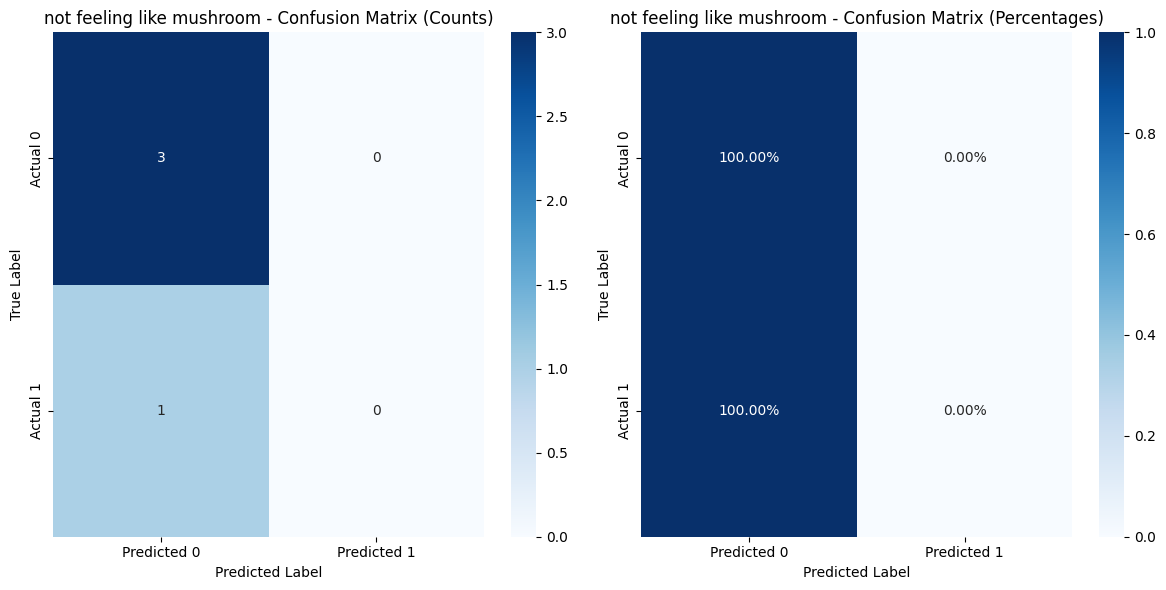

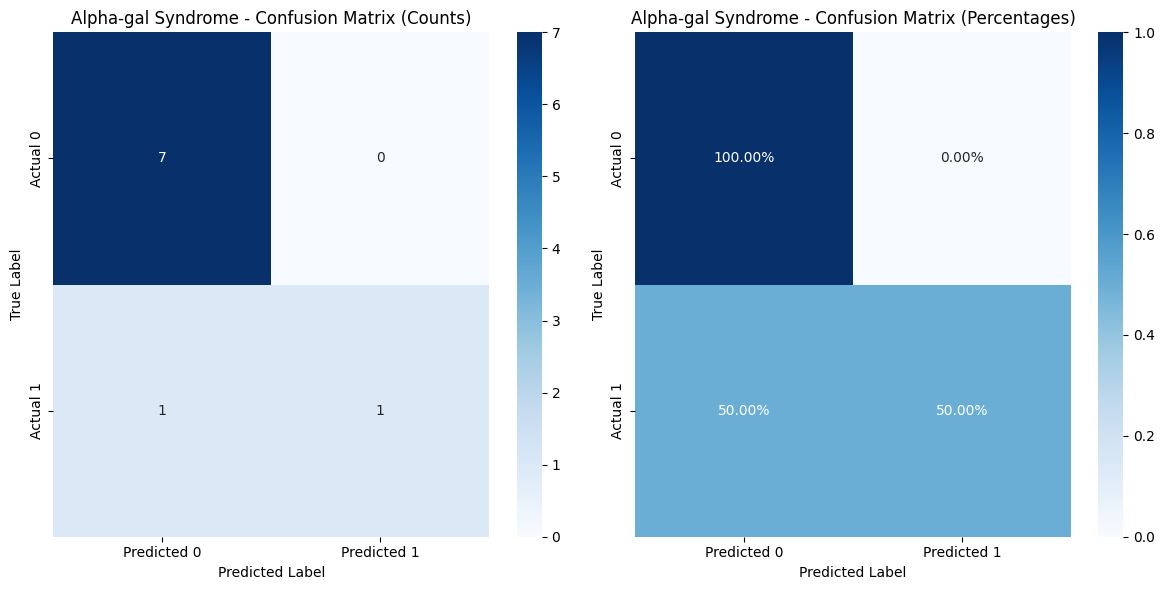

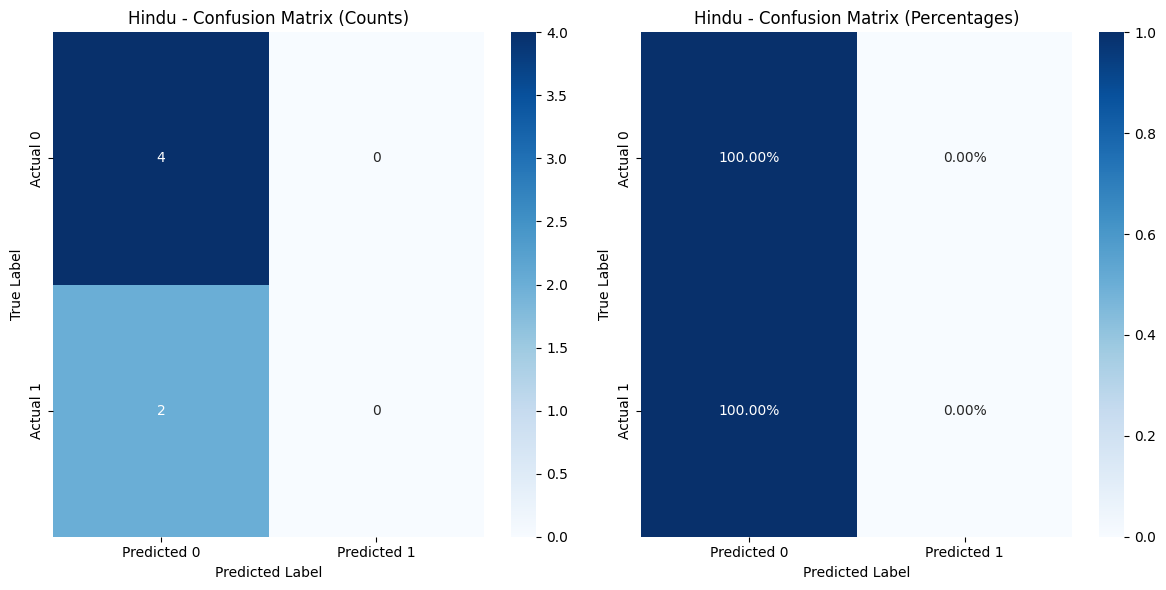

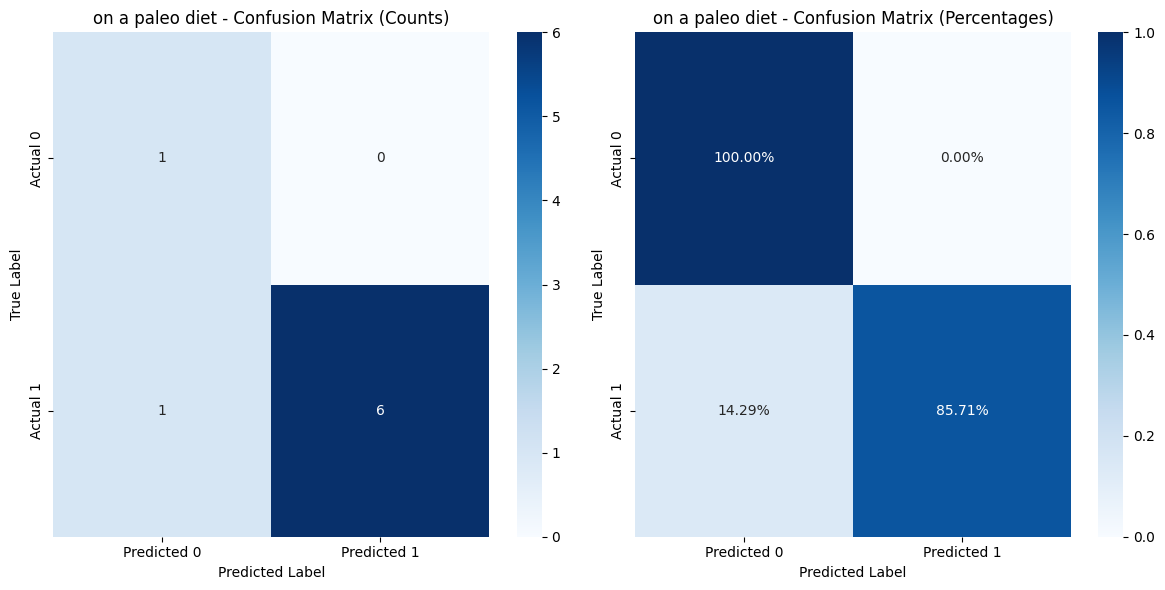

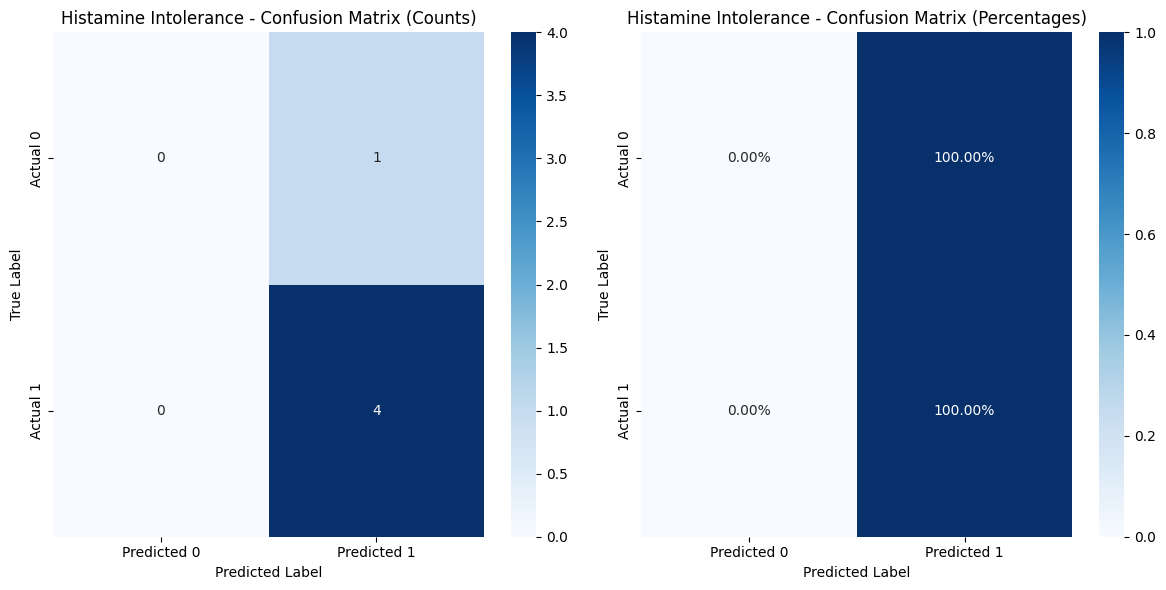

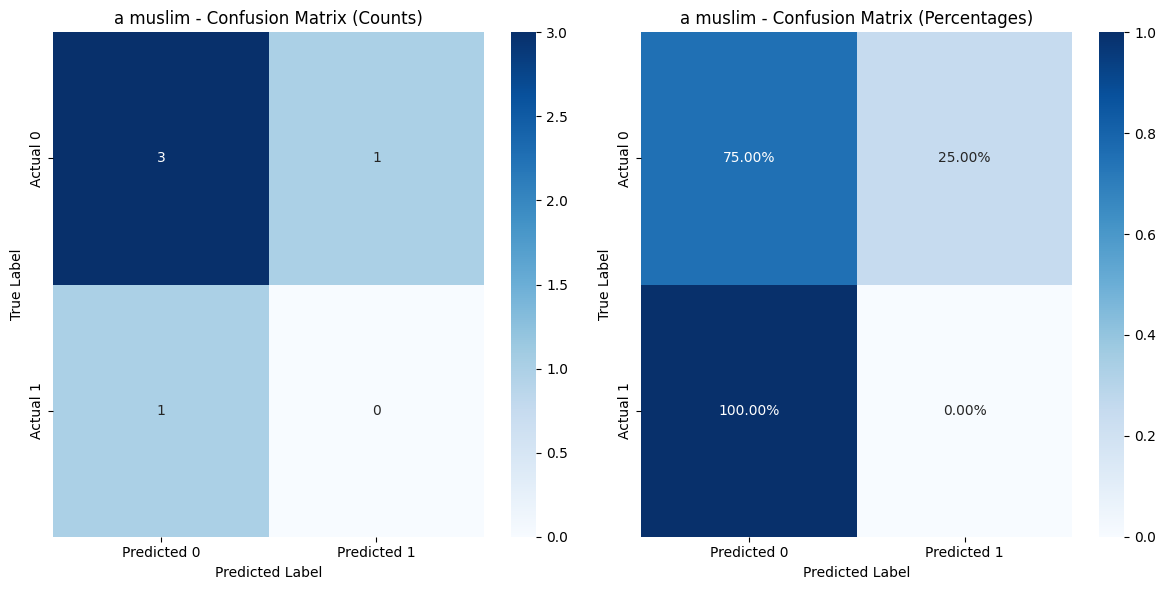

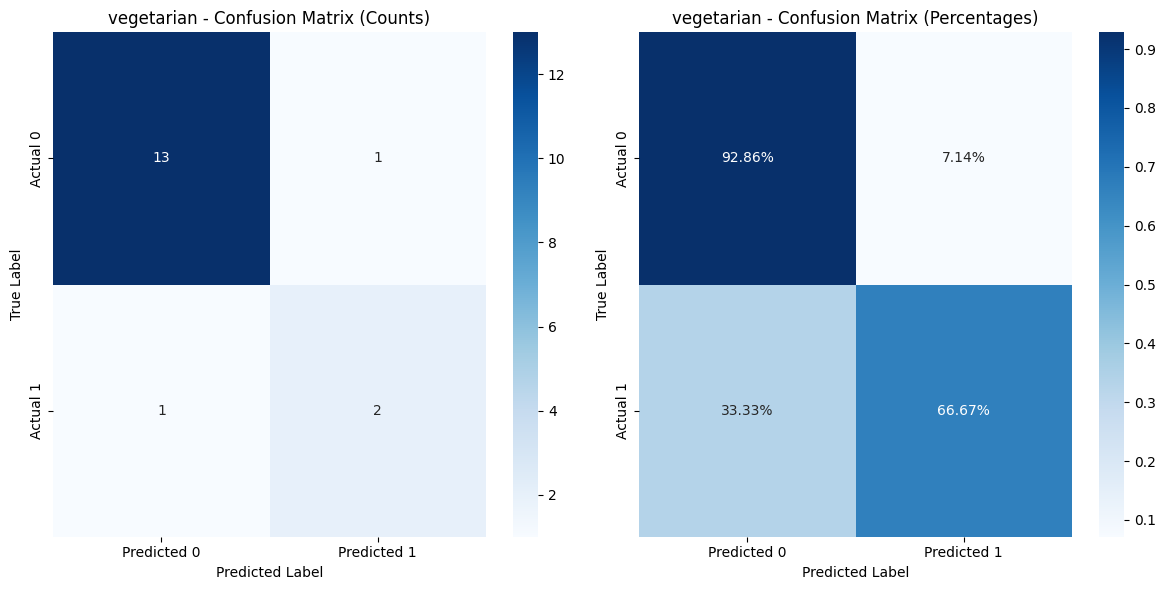

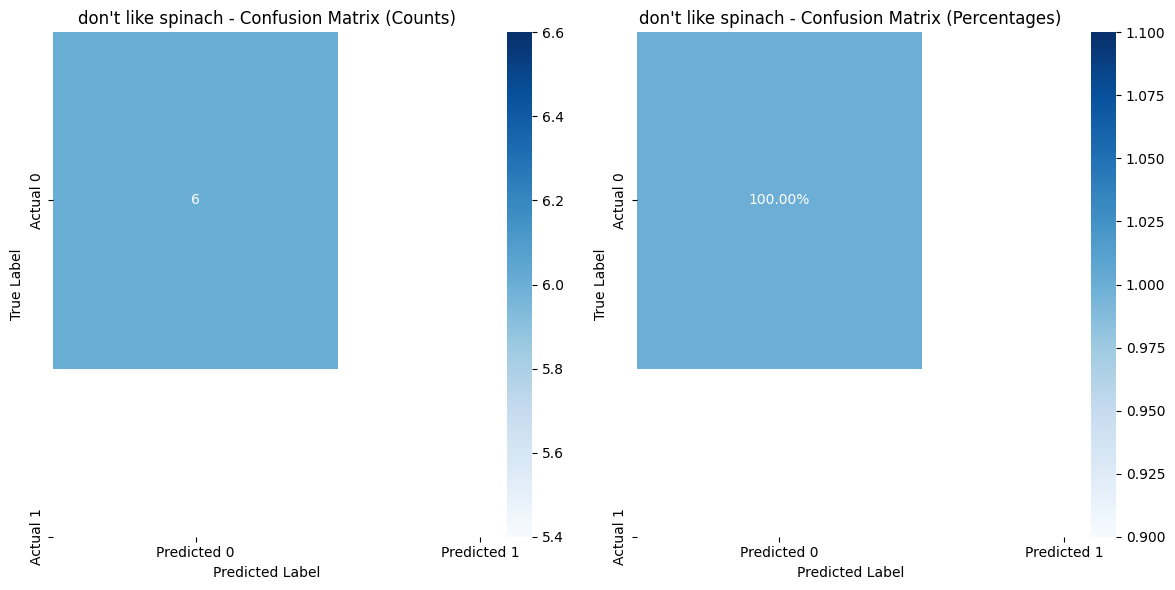

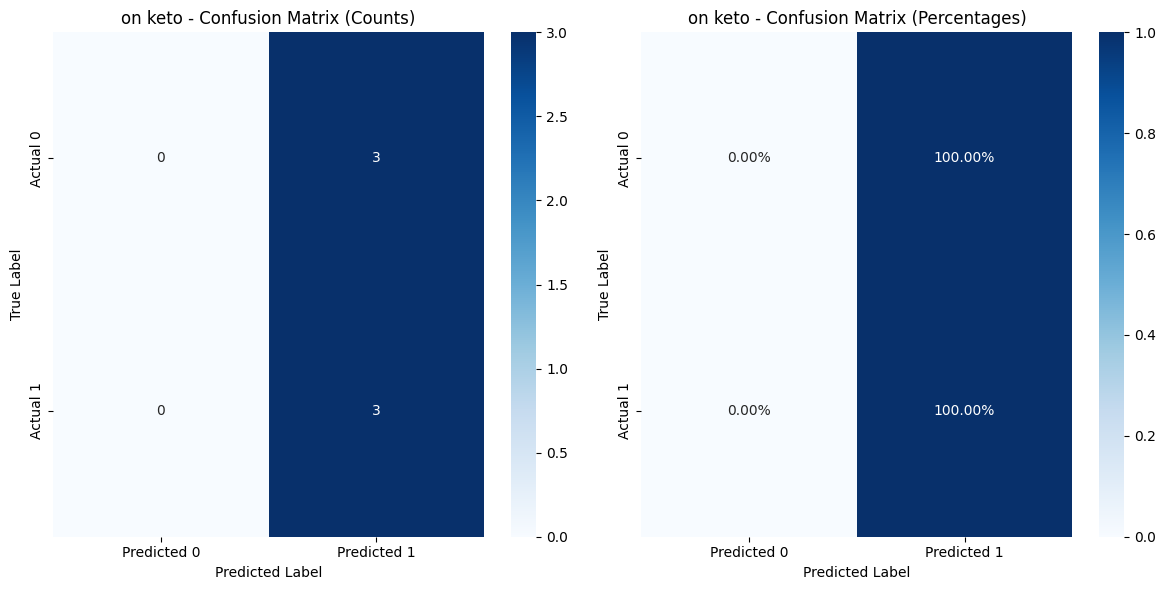

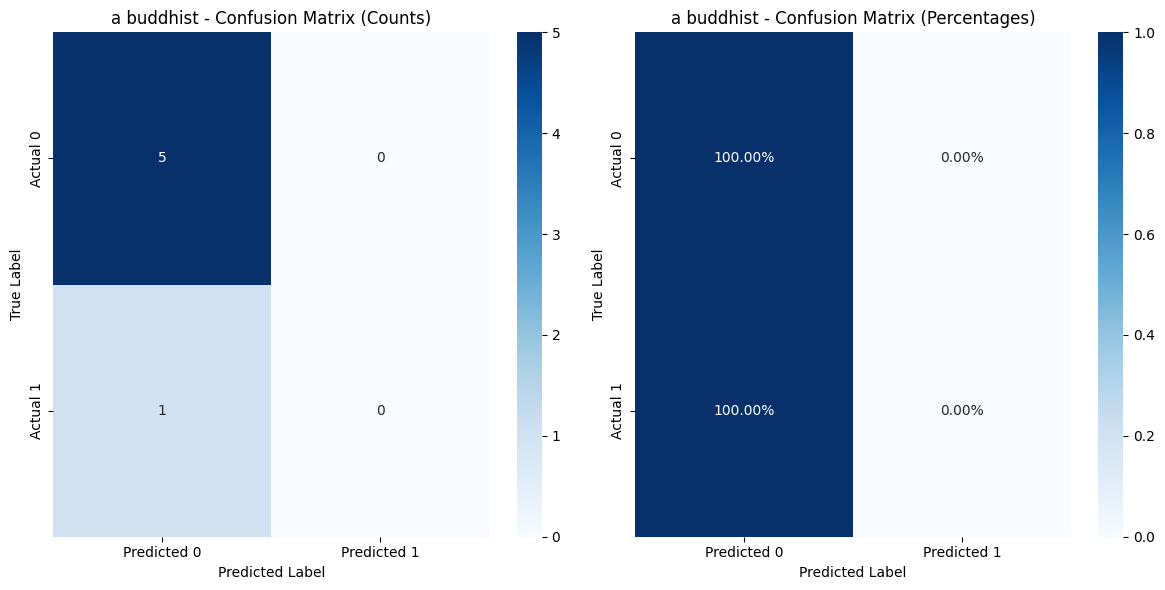

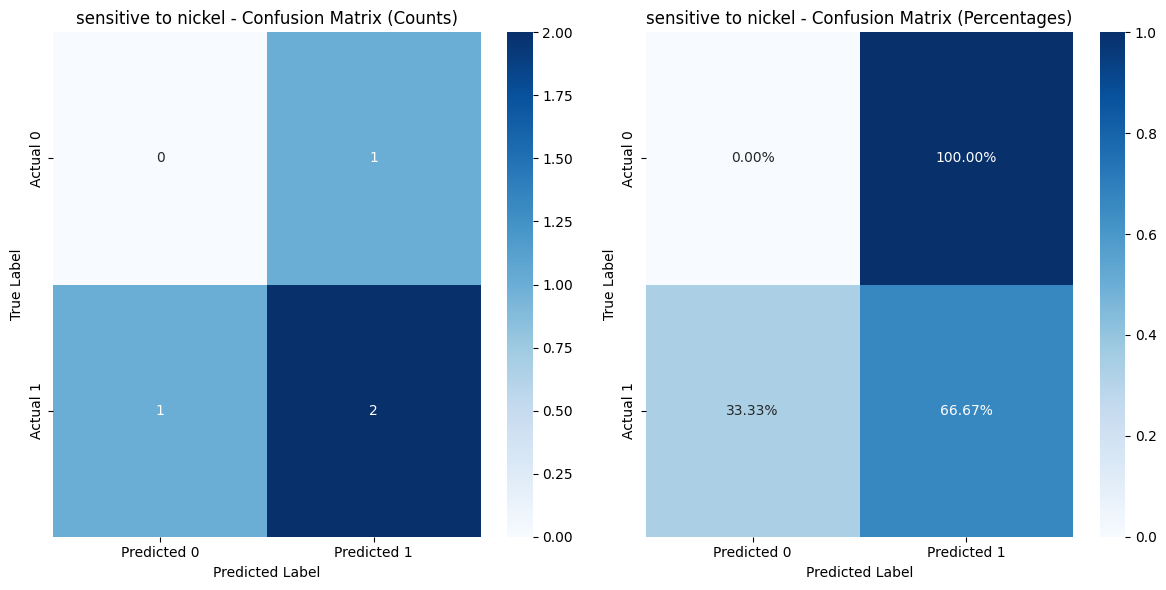

In [34]:
for i in test_df.Diet.unique():
    diet_test_label = test_df[test_df['Diet'] == i]['label'].tolist()
    diet_test_pred = predicted_test[test_df['Diet'] == i]
    # Compute confusion matrices
    cm_counts = confusion_matrix(diet_test_label, diet_test_pred)
    cm_percentages = cm_counts / np.sum(cm_counts, axis=1, keepdims=True)

    # Plot confusion matrices side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Confusion matrix with counts
    sns.heatmap(cm_counts, annot=True, cmap='Blues', fmt='g', ax=axes[0], xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    axes[0].set_title(f'{i} - Confusion Matrix (Counts)')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Confusion matrix with percentages
    sns.heatmap(cm_percentages, annot=True, cmap='Blues', fmt='.2%', ax=axes[1], xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    axes[1].set_title(f'{i} - Confusion Matrix (Percentages)')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()


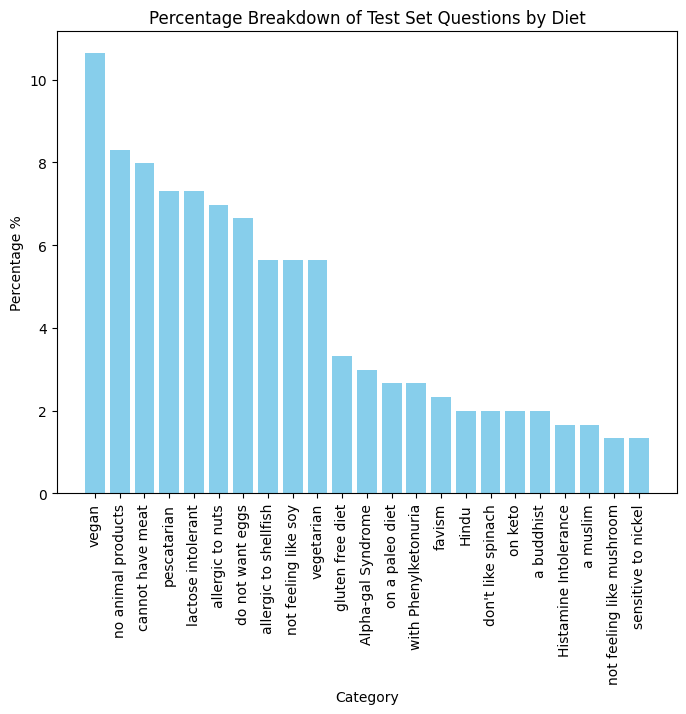

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each value in the 'Diet' column
value_counts = test_df['Diet'].value_counts()
value_percentages = (value_counts / len(test_df)) * 100

# Plot bar graph
plt.figure(figsize=(8, 6))
plt.bar(value_percentages.index, value_percentages.values, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Percentage %')
plt.title('Percentage Breakdown of Test Set Questions by Diet')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

## Information Retrivel as a Pre-Processing

We evaluate on the ones the model falsely identify
(an accuracy chart by diet type + 2 prompt and answer examples).

We feel like for harder diets, like hindu, keto, and special allergies, the model does not fully understand what the diet is. We want to refer to some articles that are about the diet, and use information retrivel model to summarize the diet behavious. Hopefully adding this to prompt would better frame the question & allow the model to have better results.

### Article

In [29]:
# https://en.wikipedia.org/wiki/List_of_diets

wiki_article = """
An individual's diet is the sum of food and drink that one habitually consumes. Dieting is the practice of attempting to achieve or maintain a certain weight through diet.[1] People's dietary choices are often affected by a variety of factors, including ethical and religious beliefs, clinical need, or a desire to control weight.

Not all diets are considered healthy. Some people follow unhealthy diets through habit, rather than through a conscious choice to eat unhealthily. Terms applied to such eating habits include "junk food diet" and "Western diet". Many diets are considered by clinicians to pose significant health risks and minimal long-term benefit. This is particularly true of "crash" or "fad" diets – short-term, weight-loss plans that involve drastic changes to a person's normal eating habits.

Belief-based diets
Some people's dietary choices are influenced by their religious, spiritual or philosophical beliefs.

Buddhist diet: While Buddhism does not have specific dietary rules, some Buddhists practice vegetarianism based on Mahayana Buddhism's strict interpretation of the first of the Five Precepts.[2]
Hindu diet: It is popular for followers of Hinduism to follow lacto vegetarian diets (though most do not), based on the principle of ahimsa (non-harming).[3] Consuming beef/cattle is forbidden or at least taboo among followers due to cow veneration. Most Hindus in India do intentionally limit their meat consumption one way or another.[4]
Jain diet: Due to how the Jain faith interprets ahisma, vegetarianism is considered mandatory for followers; a lacto-vegetarian diet[5] or vegan diet[6] in particular is considered appropriate for Jains. Most Jains also abstain from consuming root vegetables in order to prevent harming insects, worms and microorganisms when they are uprooted. Most also partake in some form of fasting.[4] Some variants of Jainism further discourage or forbid the consumption of honey, fungi, alcoholic beverages and fermented foods.
Islamic diet: Muslims follow a diet consisting solely of food that is halal – permissible in Islam. The opposite of halal is haraam, food that is Islamically Impermissible. Haraam substances include alcohol, carnivores, pork and other non-ruminant animals, and any meat from an animal which was not killed through the Islamic method of ritual slaughter (Dhabiha).[7] If an otherwise Halal animal was subject to torture by humans, its meat can still be considered non-permissible for Muslims.
I-tal: A set of principles which influences the diet of many members of the Rastafari movement. One principle is that natural foods should be consumed. Emphasis is put on consuming produce that is fresh, organic and ideally grown at home or locally. Another principle involves avoiding "unclean" types of food; the definition which is influenced by Biblical teachings. In order to preserve "life energy" Rastafarians encourage teetotalism, and many Rastafarians interpret I-tal to advocate vegetarianism or veganism as well.[8] Many followers do view seafood as an acceptable addition to an I-tal diet but they restrict which kinds they permit; fish over a foot long are typically avoided and all shellfish are eschewed as they are not Kosher animals—unlike finned-fish with scales.
Kosher diet: Food permissible under Kashrut, the set of Jewish dietary laws, is said to be Kosher. Some foods and food combinations are non-Kosher, and failure to prepare food in accordance with Kashrut can make otherwise permissible foods non-Kosher.[9]
Seventh-day Adventist diet: Combines the Kosher food rules of Judaism with prohibitions against alcoholic beverages and (sometimes) caffeinated beverages. There is emphasis on consuming whole foods. Meat-consumption is heavily discouraged but not necessarily disallowed; about half of Adventists are lacto-ovo-vegetarians.[10] Vegan and pescetarian diets are also more popular among Adventists compared to the general public[11] but other Adventists are still willing to eat Kosher meats.
Word of Wisdom diet: The name of a section of the Doctrine and Covenants, a book of scripture accepted by members of the Church of Jesus Christ of Latter-day Saints. Dietary advice includes (1) wholesome plants "in the season thereof", (2) eating meat sparingly and only "in times of winter, or of cold, or famine", and (3) grain as the "staff of life".[12] Unlike injunctions against tobacco, alcohol, coffee and tea—compliance with meat-avoidance has always remained optional among the Church of Jesus Christ of Latter-day Saints and emphasis on refraining from meat has largely been dropped.[13] An official church publication states, "modern methods of refrigeration now make it possible to preserve meat in any season".[14]
Calorie and weight control diets

Main article: Dieting
A desire to lose weight is a common motivation to change dietary habits, as is a desire to maintain an existing weight. Many weight loss diets are considered by some to entail varying degrees of health risk, and some are not widely considered to be effective. This is especially true of "crash" or "fad" diets.[15]

Many of the diets listed below could fall into more than one subcategory. Where this is the case, it is noted in that diet's entry.

Low-calorie diets: a dietary regimen that reduces the energy intake from foods and beverages without incurring malnutrition.The possible effect of calorie restriction on body weight management, longevity, and aging-associated diseases has been an active area of research.
5:2 diet: an intermittent fasting diet
Intermittent fasting: Cycling between non-fasting and fasting as a method of calorie restriction.[16]
Body for Life: A calorie-control diet, promoted as part of the 12-week Body for Life program.[17]
Cookie diet: A calorie control diet in which low-fat cookies are eaten to quell hunger, often in place of a meal.[18]
The Hacker's Diet: A calorie-control diet from The Hacker's Diet by John Walker. The book suggests that the key to reaching and maintaining the desired weight is understanding and carefully monitoring calories consumed and used.
Nutrisystem diet: The dietary element of the weight-loss plan from Nutrisystem, Inc. Nutrisystem distributes low-calorie meals, with specific ratios of fats, proteins and carbohydrates.[19]
Weight Watchers diet: Foods are assigned point values; dieters can eat any food with a point value provided they stay within their daily point limit.[20]

Very low calorie diets: A very low calorie diet is consuming fewer than 800 calories per day. Such diets are normally followed under the supervision of a doctor. Zero-calorie diets are also included.

Inedia (breatharian diet): A diet in which no food is consumed, based on the belief that prana but not food is necessary for human subsistence.[22]
KE diet (feeding tube diet): A diet in which an individual feeds through a feeding tube and does not eat anything.[23]
The Last Chance diet: General premise is that the dieter will consume only one low-calorie high protein beverage daily. This equated to no more than 400 calories per day.[24][25]
Tongue Patch Diet: Stitching a Marlex patch to the tongue to make eating painful. Daily calories are then limited to 800 per day maximum in liquid form.
Low-carbohydrate diets

Atkins diet: A low-carbohydrate diet, popularized by nutritionist Robert Atkins in the late-20th and early-21st centuries.[26] Proponents argue that this approach is a more successful way of losing weight than low-calorie diets;[27] critics argue that a low-carb approach poses increased health risks.[28] The Atkins diet consists of four phases (Induction, Balancing, Fine-Tuning and Maintenance) with a gradual increase in consumption of carbohydrates as the person goes through the phases.[29]
Dukan Diet: A multi-step diet based on high protein and limited carbohydrate consumption. It starts with two steps intended to facilitate short term weight loss, followed by two steps intended to consolidate these losses and return to a more balanced long-term diet.[30]
Kimkins: A heavily promoted diet for weight loss, found to be fraudulent.
South Beach Diet: Diet developed by the Miami-based cardiologist Arthur Agatston, who says that the key to losing weight quickly and getting healthy is not cutting all carbohydrates and fats from the diet, but choosing the right carbs and the right fats.[31]
Stillman diet: A carbohydrate-restricted diet that predates the Atkins diet, allowing consumption of specific food ingredients.
Low-fat diets
Main article: Low-fat diet
McDougall's starch diet is a high calorie, high fiber, low fat diet that is based on starches such as potatoes, rice, and beans which excludes all animal foods and added vegetable oils. John A. McDougall draws on historical observation of how many civilizations around the world throughout time have thrived on starch foods.
Crash diets
Crash diets are very-low-calorie diets used for the purpose of very fast weight loss.[32][33][34] They describe diet plans that involve making extreme, rapid changes to food consumption, but are also used as disparaging terms for common eating habits which are considered unhealthy. This diet is dangerous and can lead to sudden death when not done in a medically supervised setting.[35][36] Several diets listed here are weight-loss diets which would also fit into other sections of this list. Where this is the case, it will be noted in that diet's entry.

Beverly Hills Diet: An extreme diet which has only fruits in the first days, gradually increasing the selection of foods up to the sixth week.[37]
Cabbage soup diet: A low-calorie diet based on heavy consumption of cabbage soup. Considered a fad diet.[38]
Grapefruit diet: A fad diet, intended to facilitate weight loss, in which grapefruit is consumed in large quantities at meal times.[39]
Monotrophic diet: A diet that involves eating only one food item, or one type of food, for a period of time to achieve a desired weight reduction.
Subway diet: A crash diet[40] in which a person consumes Subway sandwiches in place of higher calorie fast foods. Made famous by convicted sex offender and former obese student Jared Fogle, who lost 245 pounds after replacing his meals with Subway sandwiches as part of an effort to lose weight.[40]
Detox diets
Detox diets involve either not consuming or attempting to flush out substances that are considered unhelpful or harmful. Examples include restricting food consumption to foods without colorings or preservatives, taking supplements, or drinking large amounts of water. The latter practice in particular has drawn criticism, as drinking significantly more water than recommended levels can cause hyponatremia.[41] There is no scientific evidence of any benefit from detox diets, and so they are considered to be pseudoscientific.[42][43]

Juice fasting: A form of detox diet, in which nutrition is obtained solely from fruit and vegetable juices. The health implications of such diets are disputed.[44]
Master Cleanse: A modified juice fast that substitutes tea and lemonade for food.
Diets followed for medical reasons
People's dietary choices are sometimes affected by intolerance or allergy to certain types of food. There are also dietary patterns that might be recommended, prescribed or administered by medical professionals for people with specific medical needs.

DASH diet (Dietary Approaches to Stop Hypertension): A recommendation that those with high blood pressure consume large quantities of fruits, vegetables, whole-grains and low fat dairy foods as part of their diet, and avoid sugar sweetened foods, red meat and fats. Promoted by the US Department of Health and Human Services, a United States government organisation.[45]
Diabetic diet: An umbrella term for diets recommended to people with diabetes. There is considerable disagreement in the scientific community as to what sort of diet is best for people with diabetes.[46]
Elemental diet: A medical, liquid-only diet, in which liquid nutrients are consumed for ease of ingestion.[47]
Elimination diet: A method of identifying foods which cause a person adverse effects, by process of elimination.[48]
Gluten-free diet: A diet which avoids the protein gluten, which is found in barley, rye and wheat. It is a medical treatment for gluten-related disorders, which include coeliac disease, non-celiac gluten sensitivity, gluten ataxia, dermatitis herpetiformis and wheat allergy.[49][50][51][52]
Gluten-free, casein-free diet: A gluten-free diet which also avoids casein, a protein commonly found in milk and cheese. This diet has been researched for efficacy in treatment of autism spectrum disorder.[53]
Healthy kidney diet: This diet is for those impacted with chronic kidney disease, those with only one kidney, those who have a kidney infection and those who may be suffering from some other kidney failure.[54] This diet is not the dialysis diet,[55] which is completely different. The healthy kidney diet restricts large amounts of protein, which are hard for the kidney to break down, but especially limits potassium and phosphorus-rich foods and beverages. Liquid intake is often limited as well.[54][56]
Ketogenic diet (Keto): A high-fat, low-carb diet, in which dietary and body fat is converted into energy. It is used as a medical treatment for refractory epilepsy.[57]
Liquid diet: A diet in which only liquids are consumed. May be administered by clinicians for medical reasons, such as after a gastric bypass[58] or to prevent death through starvation from a hunger strike.[59]
Low-FODMAP diet: A diet that consists in the global restriction of all fermentable carbohydrates (FODMAPs).
Soft diet: A mechanical soft diet or edentulous diet, or soft food(s) diet, is a diet that involves only foods that are physically soft, with the goal of reducing or eliminating the need to chew the food
Specific carbohydrate diet: A diet that aims to restrict the intake of complex carbohydrates such as found in grains and complex sugars.[60]
Fad diets: A fad diet is a diet that is popular for a time, similar to fads in fashion, without being a standard dietary recommendation, and often promising unreasonably fast weight loss or nonsensical health improvements.[61][62][63][64][65] There is no single definition of what a fad diet is, encompassing a variety of diets with different approaches and evidence bases, and thus different outcomes, advantages and disadvantages,[62] and it is ever-changing.[61][62] Generally, fad diets promise short-term changes with little effort, and thus may lack educating consumers about whole-diet, whole lifestyle changes necessary for sustainable health benefits.[61][62][66][67] Fad diets are often promoted with exaggerated claims, such as rapid weight loss of more than 1 kg/week or improving health by "detoxification", or even dangerous claims.[62][63][68][69]
Nickel Allergy: Avoid all foods that are routinely high in nickel content such as cocoa, chocolate, soya beans, oatmeal, nuts, almonds and fresh and dried legumes. Avoid all drinks and vitamin supplements with nickel and canned food.: Avoid all foods that are routinely high in nickel content such as cocoa, chocolate, soya beans, oatmeal, nuts, almonds and fresh and dried legumes. Avoid all drinks and vitamin supplements with nickel and canned food.

Vegetarian diets: A vegetarian diet is one which excludes meat. Vegetarians also avoid food containing by-products of animal slaughter, such as animal-derived rennet and gelatin.[142]

Fruitarian diet: A diet which predominantly consists of raw fruit.[143]
Lacto vegetarianism: A vegetarian diet that includes certain types of dairy, but excludes eggs and foods which contain animal rennet.[144] A common diet among followers of several religions, including Hinduism, Sikhism and Jainism, based on the principle of Ahimsa (non-harming).[3]
Ovo vegetarianism: A vegetarian diet that includes eggs, but excludes dairy.
Ovo-lacto vegetarianism: A vegetarian diet that includes eggs and dairy.[144]
Vegan diet: In addition to the abstentions of a vegetarian diet, vegans do not use any product produced by animals, such as eggs, dairy products, or honey.[142] The vegan philosophy and lifestyle is broader than just the diet and also includes abstaining from using any products tested on animals and often campaigning for animal welfare and animal rights.
Semi-vegetarian diets
Semi-vegetarianism: A predominantly vegetarian diet, in which meat is occasionally consumed. This includes "flexitarian", reducetarian and demitarian diets [145] Sometimes semi-vegetarian and flexitarian diets are defined as distinct from one another, where the former is defined as abstaining from red meat while the latter simply entails only eating meat infrequently.[146][147][148]
Pescetarianism: A diet which includes seafood, but not poultry, other white meat or meat from mammals.
Pollotarianism: A diet which includes poultry, but no other white meat, seafood or meat from mammals.
Kangatarian: A diet originating from Australia. In addition to foods permissible in a vegetarian diet, kangaroo meat is also consumed.[149] The name is a protologism that may have started out as a joke rather than a dietary term or identifying label that was ever intended to be taken seriously or used unironically.[150]
Planetary health diet: Dietary paradigms that have the following aims: to feed a growing world's population, to greatly reduce the worldwide number of deaths caused by poor diet, and to be environmentally sustainable as to prevent the collapse of the natural world.[151]
Plant-based diet: A broad term to describe diets in which animal products do not form a large proportion of the diet. Under some definitions a plant-based diet is fully vegetarian; under others it is possible to follow a plant-based diet whilst occasionally consuming meat.[152]
Other diets
Alkaline diet: The avoidance of relatively acidic foods – foods with low pH levels – such as alcohol, caffeine, dairy, fungi, grains, meat, and sugar. Proponents believe such a diet may have health benefits;[153] critics consider the arguments to have no scientific basis.[154]
Clean eating
Climatarian diet: A diet focused on reducing the carbon footprint of the consumed food, particularly through the consumption of locally sourced food and the avoidance of beef and lamb meat.[155] Adherents may also be "organivores" (strong proponents of certified organic foods over intensively farmed foods).[156]
Eat-clean diet: Focuses on eating foods without preservatives, and on mixing lean proteins with complex carbohydrates.[157]
Gerson therapy: A form of alternative medicine, the diet is low salt, low fat and vegetarian, and also involves taking specific supplements. It was developed by Max Gerson, who claimed the therapy could cure cancer and chronic, degenerative diseases. These claims have not been scientifically proven, and they can cause serious illness and death.[158]
The Graham Diet: A vegetarian diet which promotes whole-wheat flour and discourages the consumption of stimulants such as alcohol and caffeine. Developed by Sylvester Graham in the 19th century.[159]
Hay diet: A food-combining diet developed by William Howard Hay in the 1920s. Divides foods into separate groups, and suggests that proteins and carbohydrates should not be consumed in the same meal.[81]
High-protein diet: A diet in which high quantities of protein are consumed with the intention of building muscle. Not to be confused with low-carb diets, where the intention is to lose weight by restricting carbohydrates.
High residue diet: A diet in which high quantities of dietary fiber are consumed. High-fiber foods include certain fruits, vegetables, nuts and grains.[160]
A group of people in winter clothing, standing around piles of meat lying on the snow.
Sharing of frozen, aged walrus meat among Inuit families
Inuit diet: Inuit traditionally consume food that is fished, hunted or gathered locally, predominantly meat and fish.[161]
Jenny Craig: A weight-loss program from Jenny Craig, Inc. It includes weight counselling among other elements. The dietary aspect involves the consumption of pre-packaged food produced by the company.[162]
Locavore diet: a neologism describing the eating of food that is locally produced, and not moved long distances to market. An example of this was explored in the book 100-Mile Diet, in which the authors only consumed food grown within 100 miles of their residence for a year.[163] People who follow this type of diet are sometimes known as locavores.
Low carbon diet: Consuming food which has been produced, prepared and transported with a minimum of associated greenhouse gas emissions.

An assortment of foods on a worktop. They are: tofu, wheat miso, bancha tea, umeboshi prumes brown rice, sea salt and nori.
Some common macrobiotic ingredients
Macrobiotic diet: A diet in which processed food is avoided. Common components include grains, beans and vegetables.[164]
Mediterranean diet: A diet based on habits of some southern European countries. One of the more distinct features is that olive oil is used as the primary source of fat.[165]
MIND diet: combines the portions of the DASH diet and the Mediterranean diet. The diet is intended to reduce neurological deterioration such as Alzheimer's disease.[166]
Montignac diet: A weight-loss diet characterised by consuming carbohydrates with a low glycemic index.[167]
Mushroom diet: A mushroom-predominant diet.
Negative calorie diet: A claim by many weight-loss diets that some foods take more calories to digest than they provide, such as celery. The basis for this claim is disputed.[168]
Okinawa diet: A low-calorie diet based on the traditional eating habits of people from the Ryukyu Islands.
Omnivorous diet: An omnivore consumes diverse range of both plant and animal-based food.[169]
Organic food diet: A diet consisting only of food which is organic – it has not been produced with modern inputs such as synthetic fertilizers, genetic modification, irradiation, antibiotics, growth hormones, or synthetic food additives.[170]
Prison loaf: A meal replacement served in some United States prisons to inmates who are not trusted to use cutlery. Its composition varies between institutions and states, but as a replacement for standard food, it is intended to provide inmates with all their dietary needs.
Raw foodism: A diet which centres on the consumption of uncooked and unprocessed food. Often associated with a vegetarian diet,[171] although some raw food dieters do consume raw meat.[172]
Shangri-La Diet
Slimming World diet
Slow-carb diet
Smart For Life
Sonoma diet: A diet based on portion control and centered around consuming "power foods"
SparkPeople diet
Sugar Busters!: Focuses on restricting the consumption of refined carbohydrates, particularly sugars.[173]
Western pattern diet (WPD): 'Default' diet in many developed countries, especially the Anglosphere. The name is from "Western world" and is interchanged with "standard American diet" and "meat-sweet diet" due to the high amount of meat (total), red meats (particularly), dairy, sweets and refined cereals.[174] Subpar intake of whole grains, legumes, tree nuts, produce and seafood is the norm.[175][176] WPDs are distinguished from other unbalanced diets by heavy inclusion of 'junk food' and other ultra-processed foods that generally provide substantial empty calories, carbohydrates, saturated fat, industrial trans fat, added sugar/free sugars, added salt, artificial flavor/sweetener and other processing ingredients. Archetypal examples include: RTE cereals, white breads, fast food, other convenience meals, cured meat dishes, smoked/fried meats, fried dough foods, shallow/deep fried potatoes, other foods intensely fried in rendered fat/refined oil, sugary/fatty discretionary foods (e.g., sauce, candy), colas and other sweetened soft drinks

"""

mayo_clinic_articles = """
People with lactose intolerance are unable to fully digest the sugar (lactose) in milk.
Histamine intolerance is an inability to break down histamine in your body, causing it to build up. Certain foods that are high in histamine or that cause your body to release histamine can give you an upset stomach, headache or allergy symptoms. Common trigger foods include fish, alcohol, and fermented or aged foods.
Alpha-gal syndrome is a type of food allergy. It makes people allergic to red meat and other products made from mammals. In the United States, the condition usually begins with the bite of the Lone Star tick.
Phenylketonuria, also called PKU, is a rare inherited disorder that causes an amino acid called phenylalanine to build up in the body. PKU is caused by a change in the phenylalanine hydroxylase (PAH) gene. A dangerous buildup can develop when a person with Phenylketonuria eats foods that contain protein or eats aspartame, an artificial sweetener. This can eventually lead to serious health problems. For the rest of their lives, people with PKU — babies, children and adults — need to follow a diet that limits phenylalanine, which is found mostly in foods that contain protein.
Favism is an acute hemolytic syndrome that occurs in patients with glucose-6-phosphate dehydrogenase (G6PD) deficiency following the ingestion of fava beans. Like the name of Favism, Fava beans is the hallmark trigger for G6PD mutation carriers, other triggers include certain medicines including aspirin, quinine and other antimalarials derived from quinine.
A paleo diet is an eating plan based on foods humans might have eaten during the Paleolithic Era. A modern paleo diet includes fruits, vegetables, lean meats, fish, eggs, nuts and seeds. These are foods that in the past people could get by hunting and gathering.
Nickel allergy is a common cause of allergic contact dermatitis. Avoid all foods that are routinely high in nickel content such as cocoa, chocolate, soya beans, oatmeal, nuts, almonds and fresh and dried legumes. Avoid all drinks and vitamin supplements with nickel and canned food.
"""

### Code

In [30]:
from InstructorEmbedding import INSTRUCTOR
embed_model = INSTRUCTOR('hkunlp/instructor-large')

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


In [31]:
from sklearn.metrics.pairwise import cosine_similarity

corpus_1 = 'Represent the Wikipedia document for retrieval: '
corpus_2_list = (wiki_article + mayo_clinic_articles).split("\n")
corpus_2_list.remove('')
corpus = [[corpus_1, x]for x in corpus_2_list]
corpus_embeddings = embed_model.encode(corpus)

diet_summary = {}
for diet_type in df_with_label.Diet.unique():
  query  = [["Represent the Wikipedia question for retrieving supporting documents: ",f"where does it mean by {diet_type} diet"]]
  query_embeddings = embed_model.encode(query)
  similarities = cosine_similarity(query_embeddings,corpus_embeddings)
  retrieved_doc_id = np.argmax(similarities)
  if np.max(similarities) > 0.9:
    diet_summary[diet_type] = corpus_2_list[retrieved_doc_id]
    print(diet_type, np.max(similarities), corpus_2_list[retrieved_doc_id])
  else:
    print(diet_type, np.max(similarities), 'None')


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 10253 has 14.74 GiB memory in use. Of the allocated memory 814.12 MiB is allocated by PyTorch, and 13.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#Append summary to df_with_label
df_with_label['PromptwithIR'] = [f"I am {diet_type}, can I have the dish or not?" for diet_type in df_with_label['Diet']]
for i in range(len(df_with_label)):
  diet_type = df_with_label.loc[i, 'Diet']
  if diet_type in diet_summary.keys():
    df_with_label.loc[i, 'PromptwithIR'] += f' {diet_summary[diet_type]}'
  df_with_label.loc[i, 'PromptwithIR'] += f' The dish contains ingredients: {df_with_label.loc[i, "Ingredients"]}'

df_with_label.to_csv('df_with_ir.csv')

In [ ]:
df_with_label['PromptwithIR'][1996]

In [ ]:
df_with_label.head()

In [92]:
# Re-sampling a random set of data points to test these new prompts on our model

prompt_with_ir_df = df_with_label.sample(frac=0.30, random_state=42)
prompt_with_ir_df.reset_index(drop=True, inplace=True)
prompt_with_ir_dataset = Dataset.from_pandas(prompt_with_ir_df)


In [93]:

def preprocess_function_using_ir_prompt(examples):
    first_sentences = []
    second_sentences = []
    choice_list = ["Yes", "No"]
    for q in examples["PromptwithIR"]:
      for i in range(2):
        first_sentences.append(q)
      for choice in choice_list:
        second_sentences.append(choice)

    # Tokenize
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True, max_length=max_seq_length)

    # Un-flatten
    dic = {'input_ids':[], 'token_type_ids':[], 'attention_mask':[]}

    for k, v in tokenized_examples.items():
        for i in range(0, len(v), 2):
            dic[k].append(v[i:i+2])

    return dic

In [94]:
encoded_prompt_with_ir = prompt_with_ir_dataset.map(preprocess_function_using_ir_prompt, batched=True, remove_columns=['Unnamed: 0.1',  'Prompt', 'Diet', 'Ingredients',
       'NewIngre', 'NewPrompt','PromptwithIR'])

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [95]:
tf_ir_set = model.prepare_tf_dataset(
    encoded_prompt_with_ir,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)


ir_predictions = model.predict(tf_ir_set)

300/300 [==============================] - 19s 62ms/step


In [96]:
ir_set_test = np.argmax(ir_predictions.logits, axis=-1)
ir_set_accuracy = accuracy.compute(predictions=ir_set_test, references=prompt_with_ir_df['label'].tolist())['accuracy']
print(f"IR Prompt accuracy: {ir_set_accuracy}")

IR Prompt accuracy: 0.7383333333333333


In [38]:
tf.keras.backend.clear_session()

All PyTorch model weights were used when initializing TFBertForMultipleChoice.

Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [98]:
ir_predictions = model_fine_tuned.predict(tf_ir_set)
ir_set_test = np.argmax(ir_predictions.logits, axis=-1)
ir_set_accuracy = accuracy.compute(predictions=ir_set_test, references=prompt_with_ir_df['label'].tolist())['accuracy']
print(f"IR Prompt accuracy: {ir_set_accuracy}")

300/300 [==============================] - 20s 62ms/step
IR Prompt accuracy: 0.7516666666666667
